In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [5]:
from statsmodels.regression.linear_model import OLS

In [6]:
df = load_pd_df("df_analysis.feather", DATA_DIR)

# Macro Time Series Error analysis

## Dräger (2015) rationality test

In [7]:
sub1 = pd_groupby(df.set_index('date_recorded').sort_index(), ['pi_de_Y', 'pi_perc_MY',], 'M', 'last')
sub1 = sub1.dropna()
sub1 = sm.add_constant(sub1)

mod1 = OLS(sub1.pi_de_Y, sub1.drop('pi_de_Y', axis=1)).fit()

In [8]:
sub2 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y', 'pi_exp_MY',], 'M', 'last')
sub2 = sub2.dropna()
sub2 = sm.add_constant(sub2)

mod2 = OLS(sub2.pi_de_Y, sub2.drop('pi_de_Y', axis=1)).fit()

In [9]:
sub3 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y_diff', 'delta_pe_MY',], 'M', 'last')
sub3 = sub3.dropna()
sub3 = sm.add_constant(sub3)

mod3 = OLS(sub3.pi_de_Y_diff, sub3.drop('pi_de_Y_diff', axis=1)).fit()

In [10]:
out = get_statsmodels_summary([mod1, mod2, mod3], cols_out=['print', 'conf_lower', 'conf_upper']).round(3)
save_pd_df(out, "tab_rationality_test.csv", GRAPHS_DIR)
out

print                                             \
                         pi_de_Y             pi_de_Y_1         pi_de_Y_diff   
const        -0.015 **\n[-2.556]  -0.044 ***\n[-7.723]   0.023 ***\n[4.691]   
delta_pe_MY                  NaN                   NaN  -1.238 **\n[-2.656]   
pi_exp_MY                    NaN   1.811 ***\n[17.538]                  NaN   
pi_perc_MY   1.334 ***\n[12.794]                   NaN                  NaN   
N                           34.0                  36.0                 34.0   
R^2                        0.836                   0.9                0.181   
R^2 adj.                   0.831                 0.898                0.155   

            conf_lower                        conf_upper            \
               pi_de_Y pi_de_Y_1 pi_de_Y_diff    pi_de_Y pi_de_Y_1   
const           -0.028    -0.056        0.013     -0.003    -0.033   
delta_pe_MY        NaN       NaN       -2.187        NaN       NaN   
pi_exp_MY          NaN     1.602          NaN        NaN     2.021   
pi_perc_MY       1.122       NaN          NaN      1.546       NaN   
N               34.000    36.000       34.000     34.000    36.000   
R^2              0.836     0.900        0.181      0.836     0.900   
R^2 adj.         0.831     0.898        0.155      0.831     0.898   

                          
            pi_de_Y_diff  
const              0.033  
delta_pe_MY       -0.289  
pi_exp_MY            NaN  
pi_perc_MY           NaN  
N                 34.000  
R^2                0.181  
R^2 adj.           0.155

In [11]:
import pymc as pm
import arviz as az

In [12]:
with pm.Model() as mod:
    alpha = pm.Normal('alpha', 0, 10, shape=(1,))
    beta = pm.Normal('beta', 0, 10, shape=(1,))
    sigma = pm.HalfNormal('sigma', 2, shape=(1,))
    
    mu = pm.Deterministic('mu', alpha + sub2.pi_exp_MY.values[:,None] @ beta)
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=sub2.pi_de_Y)
    
    idata = pm.sample(nuts_sampler='numpyro')
    posterior = pm.sample_posterior_predictive(idata)    

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:06.069801
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:10.008330
Transforming variables...
Transformation time =  0:00:00.233975


Sampling: [likelihood]


''

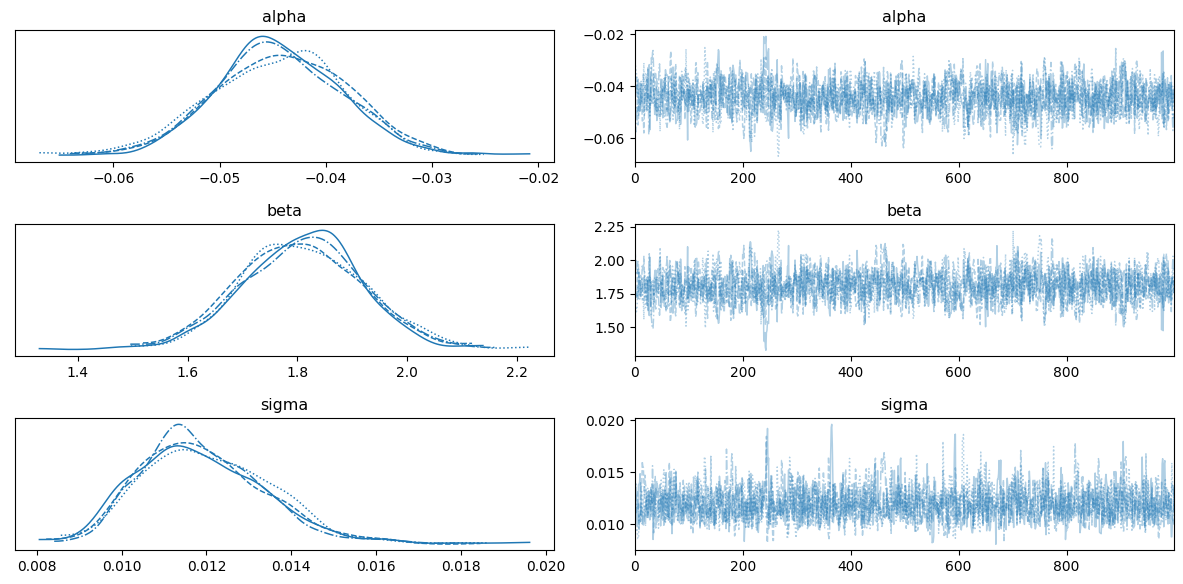

In [13]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()
;

## Cross corr

In [11]:
sub = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_MY', 'pi_perc_MY_all_error_act_MY', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_de_Y',]
].drop_duplicates()
sub2 = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_WY', 'pi_perc_MY_all_error_act_WY', 'T_sum_ind_op_diff']
].drop_duplicates()

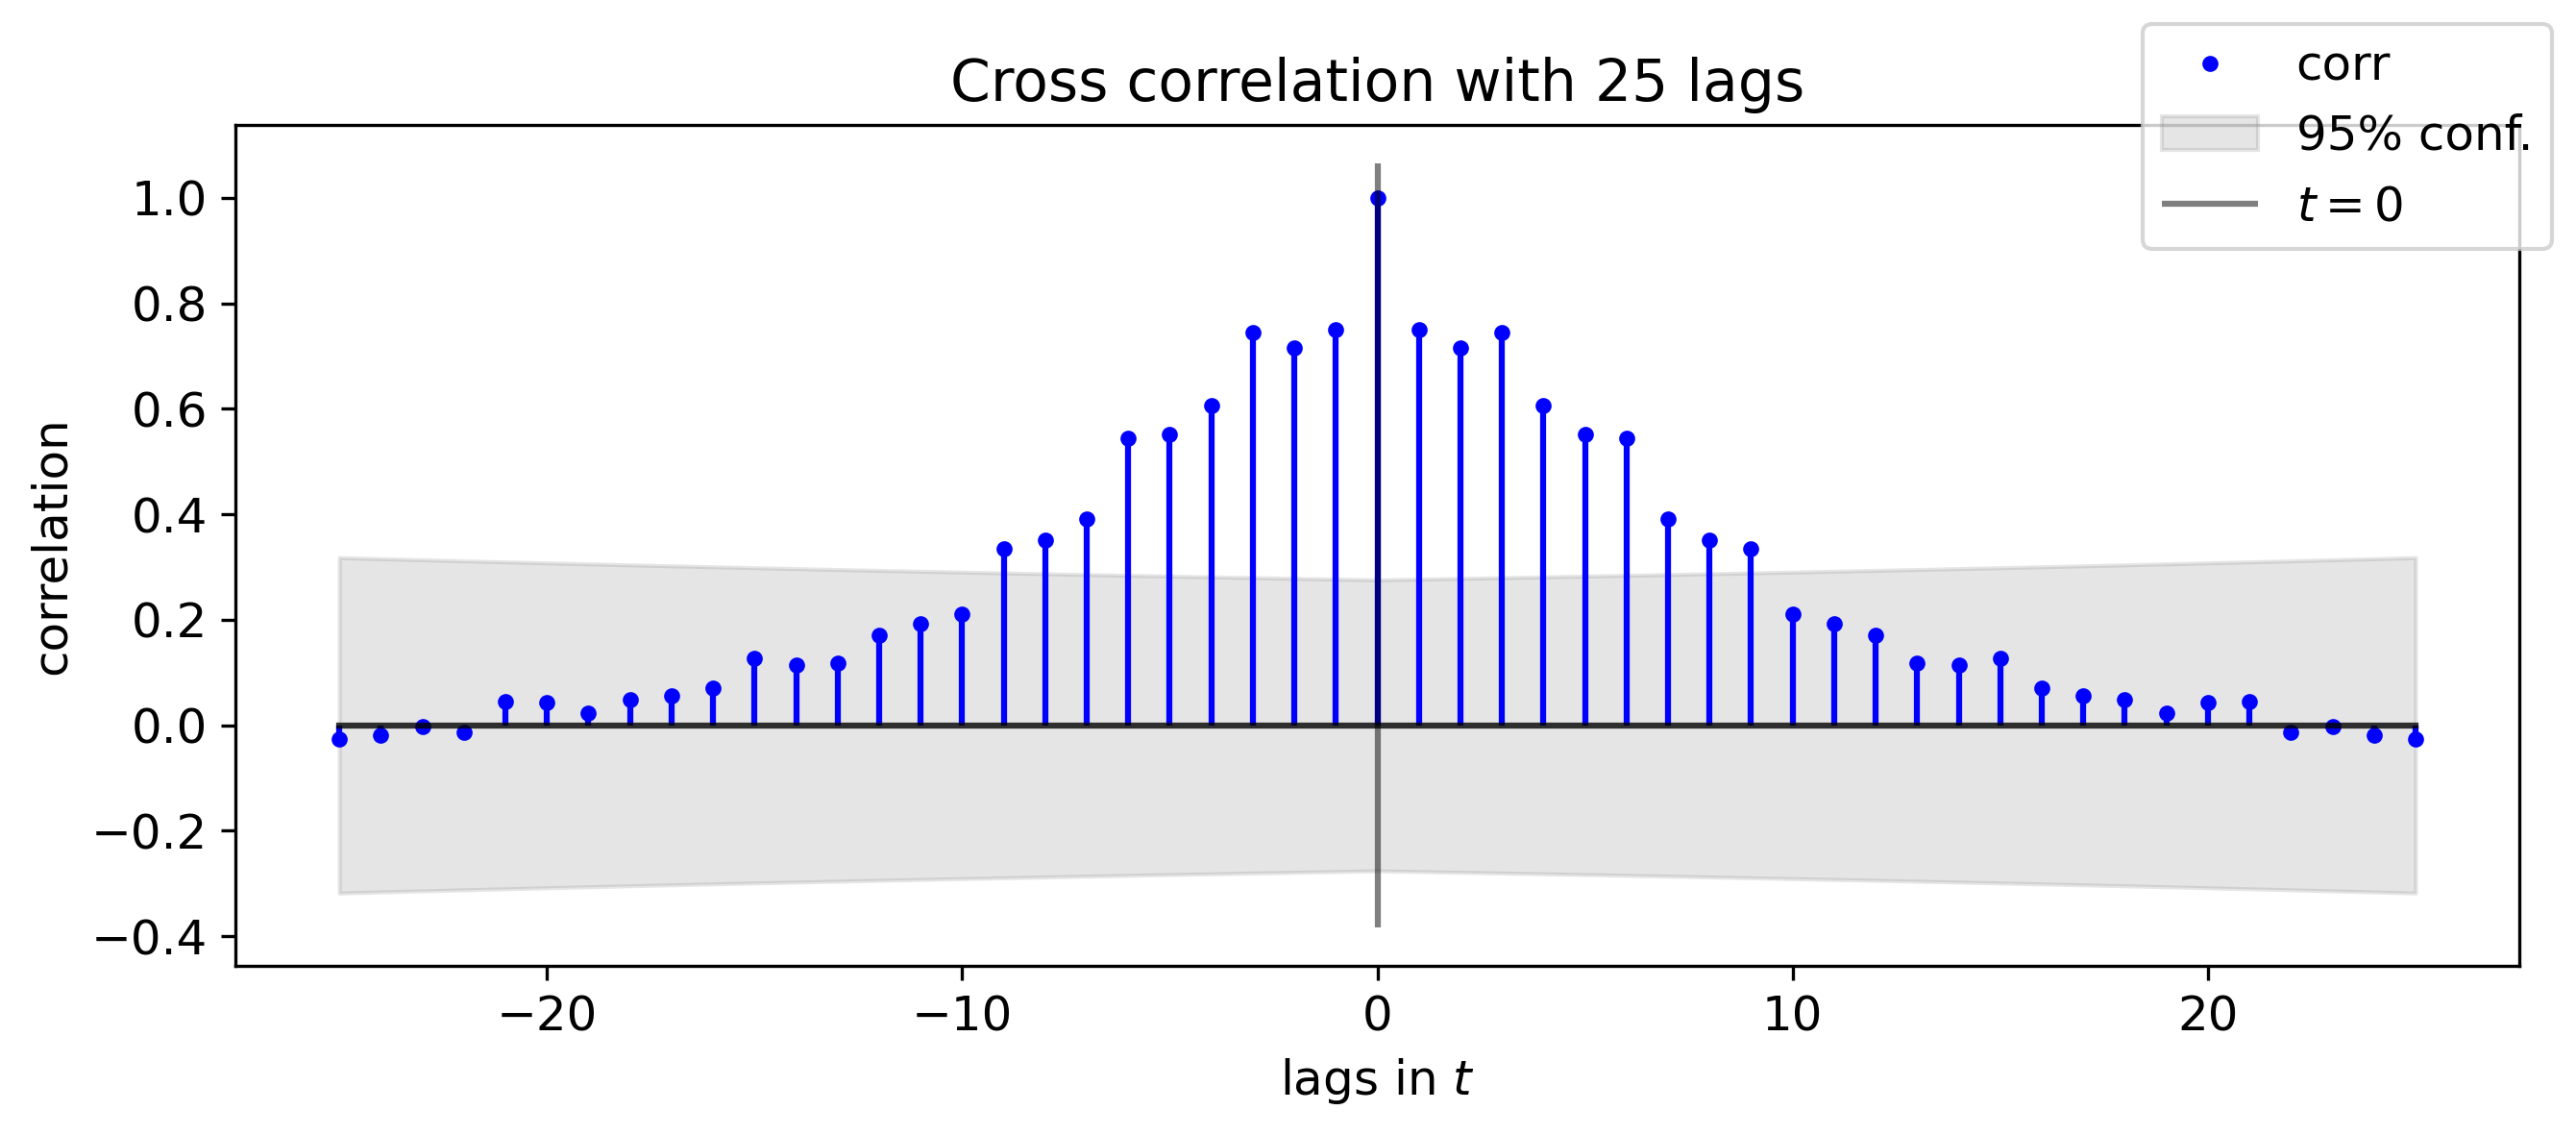

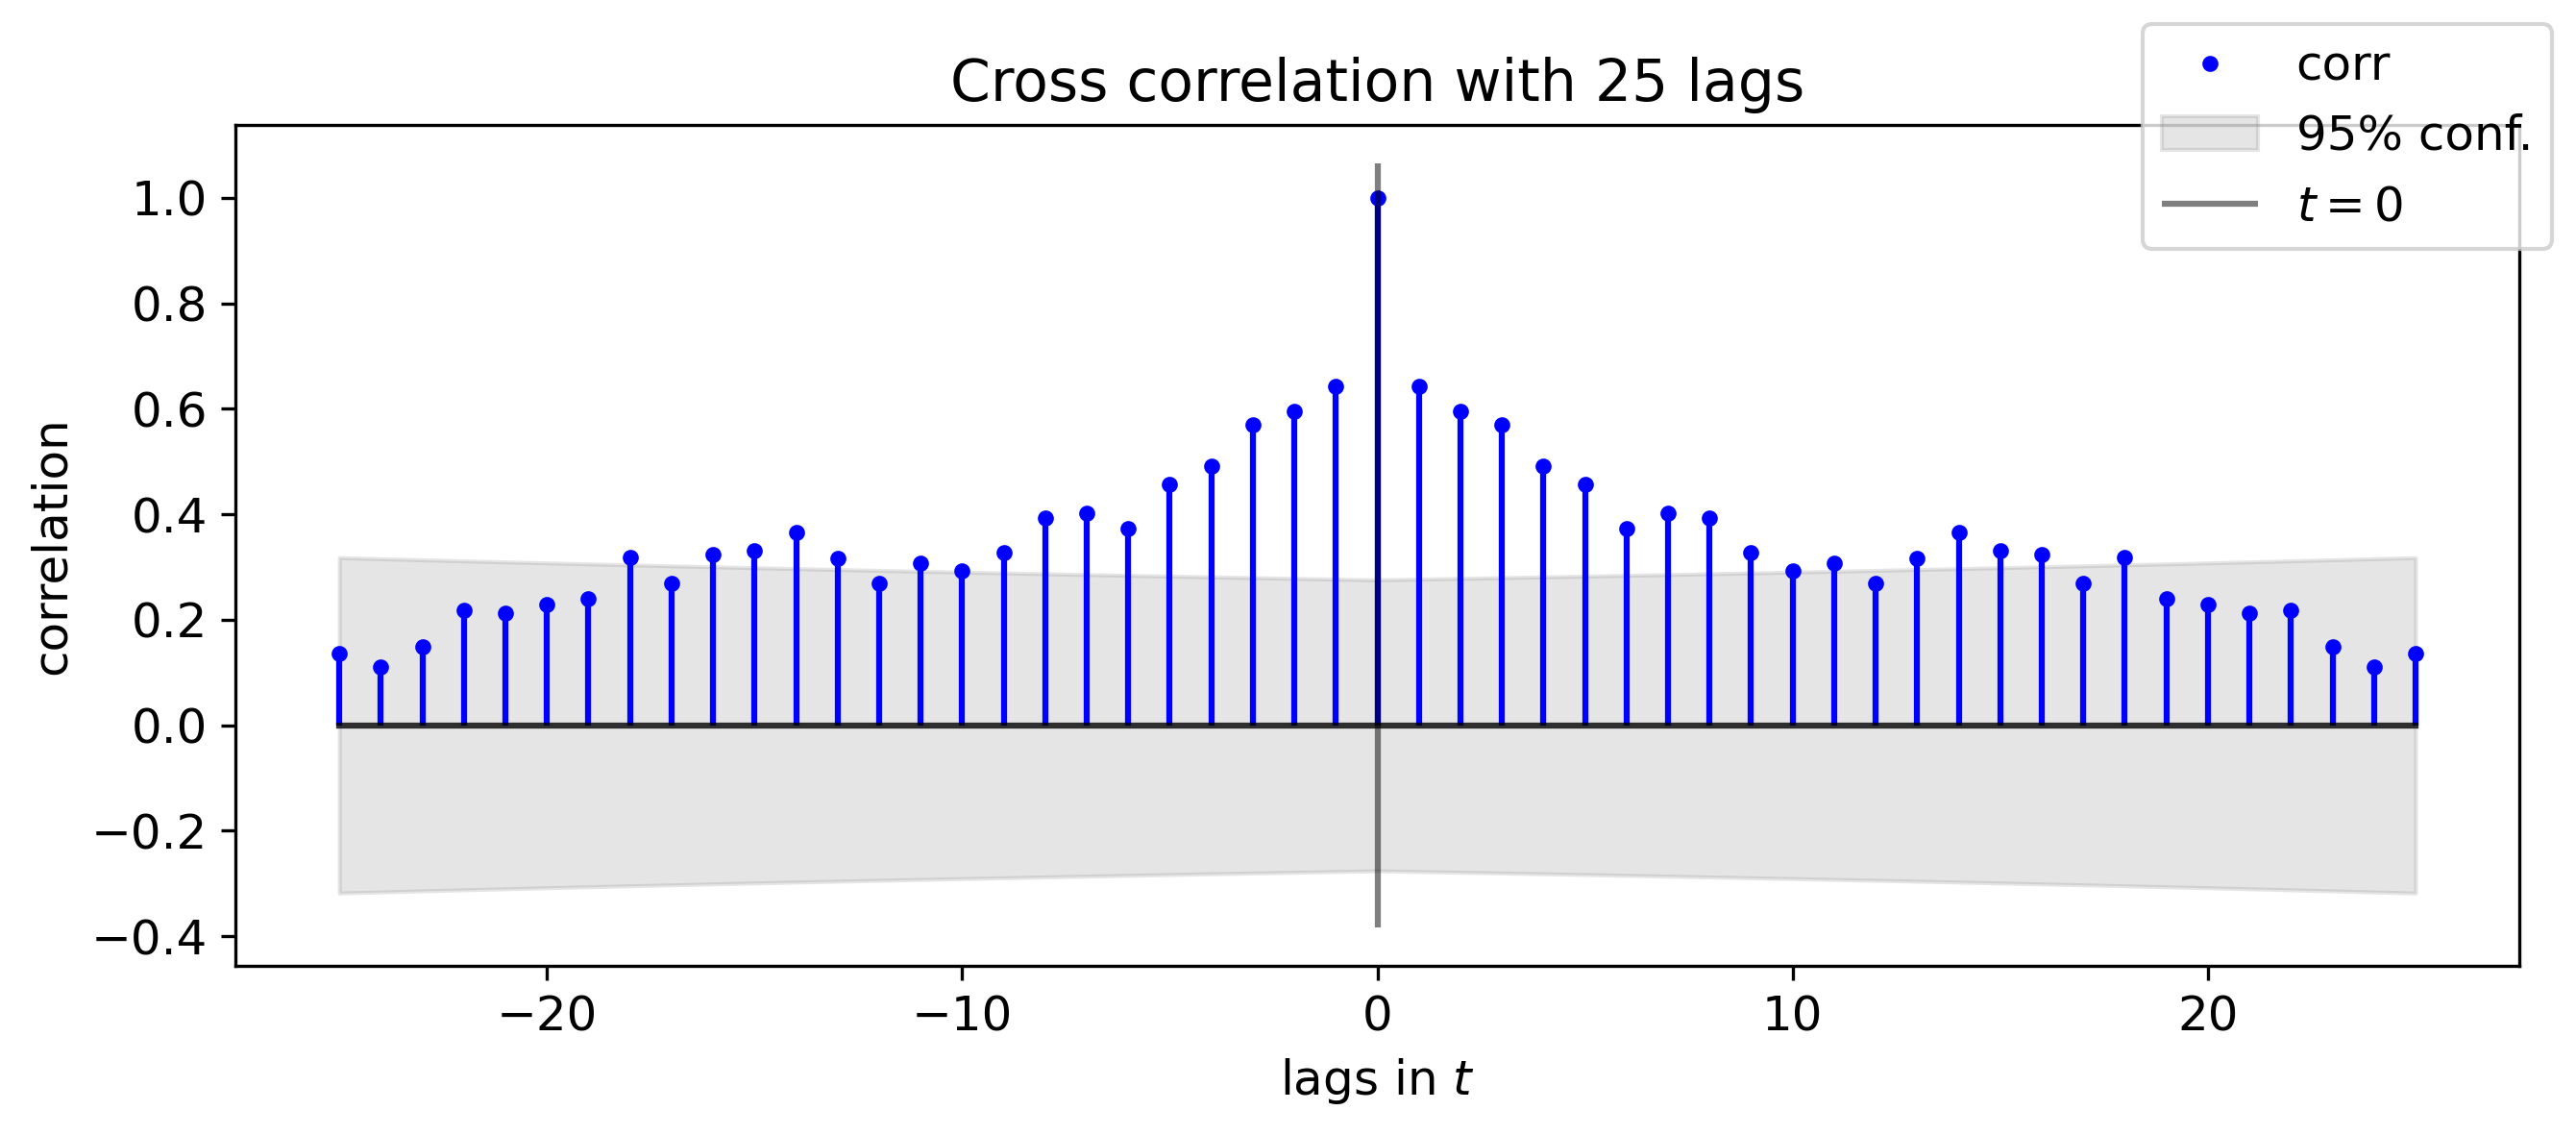

In [12]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_perc_acorr.png')
_, _, _, fig = xcorr(sub2.delta_pe_MY_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_delta_pe_acorr.png')

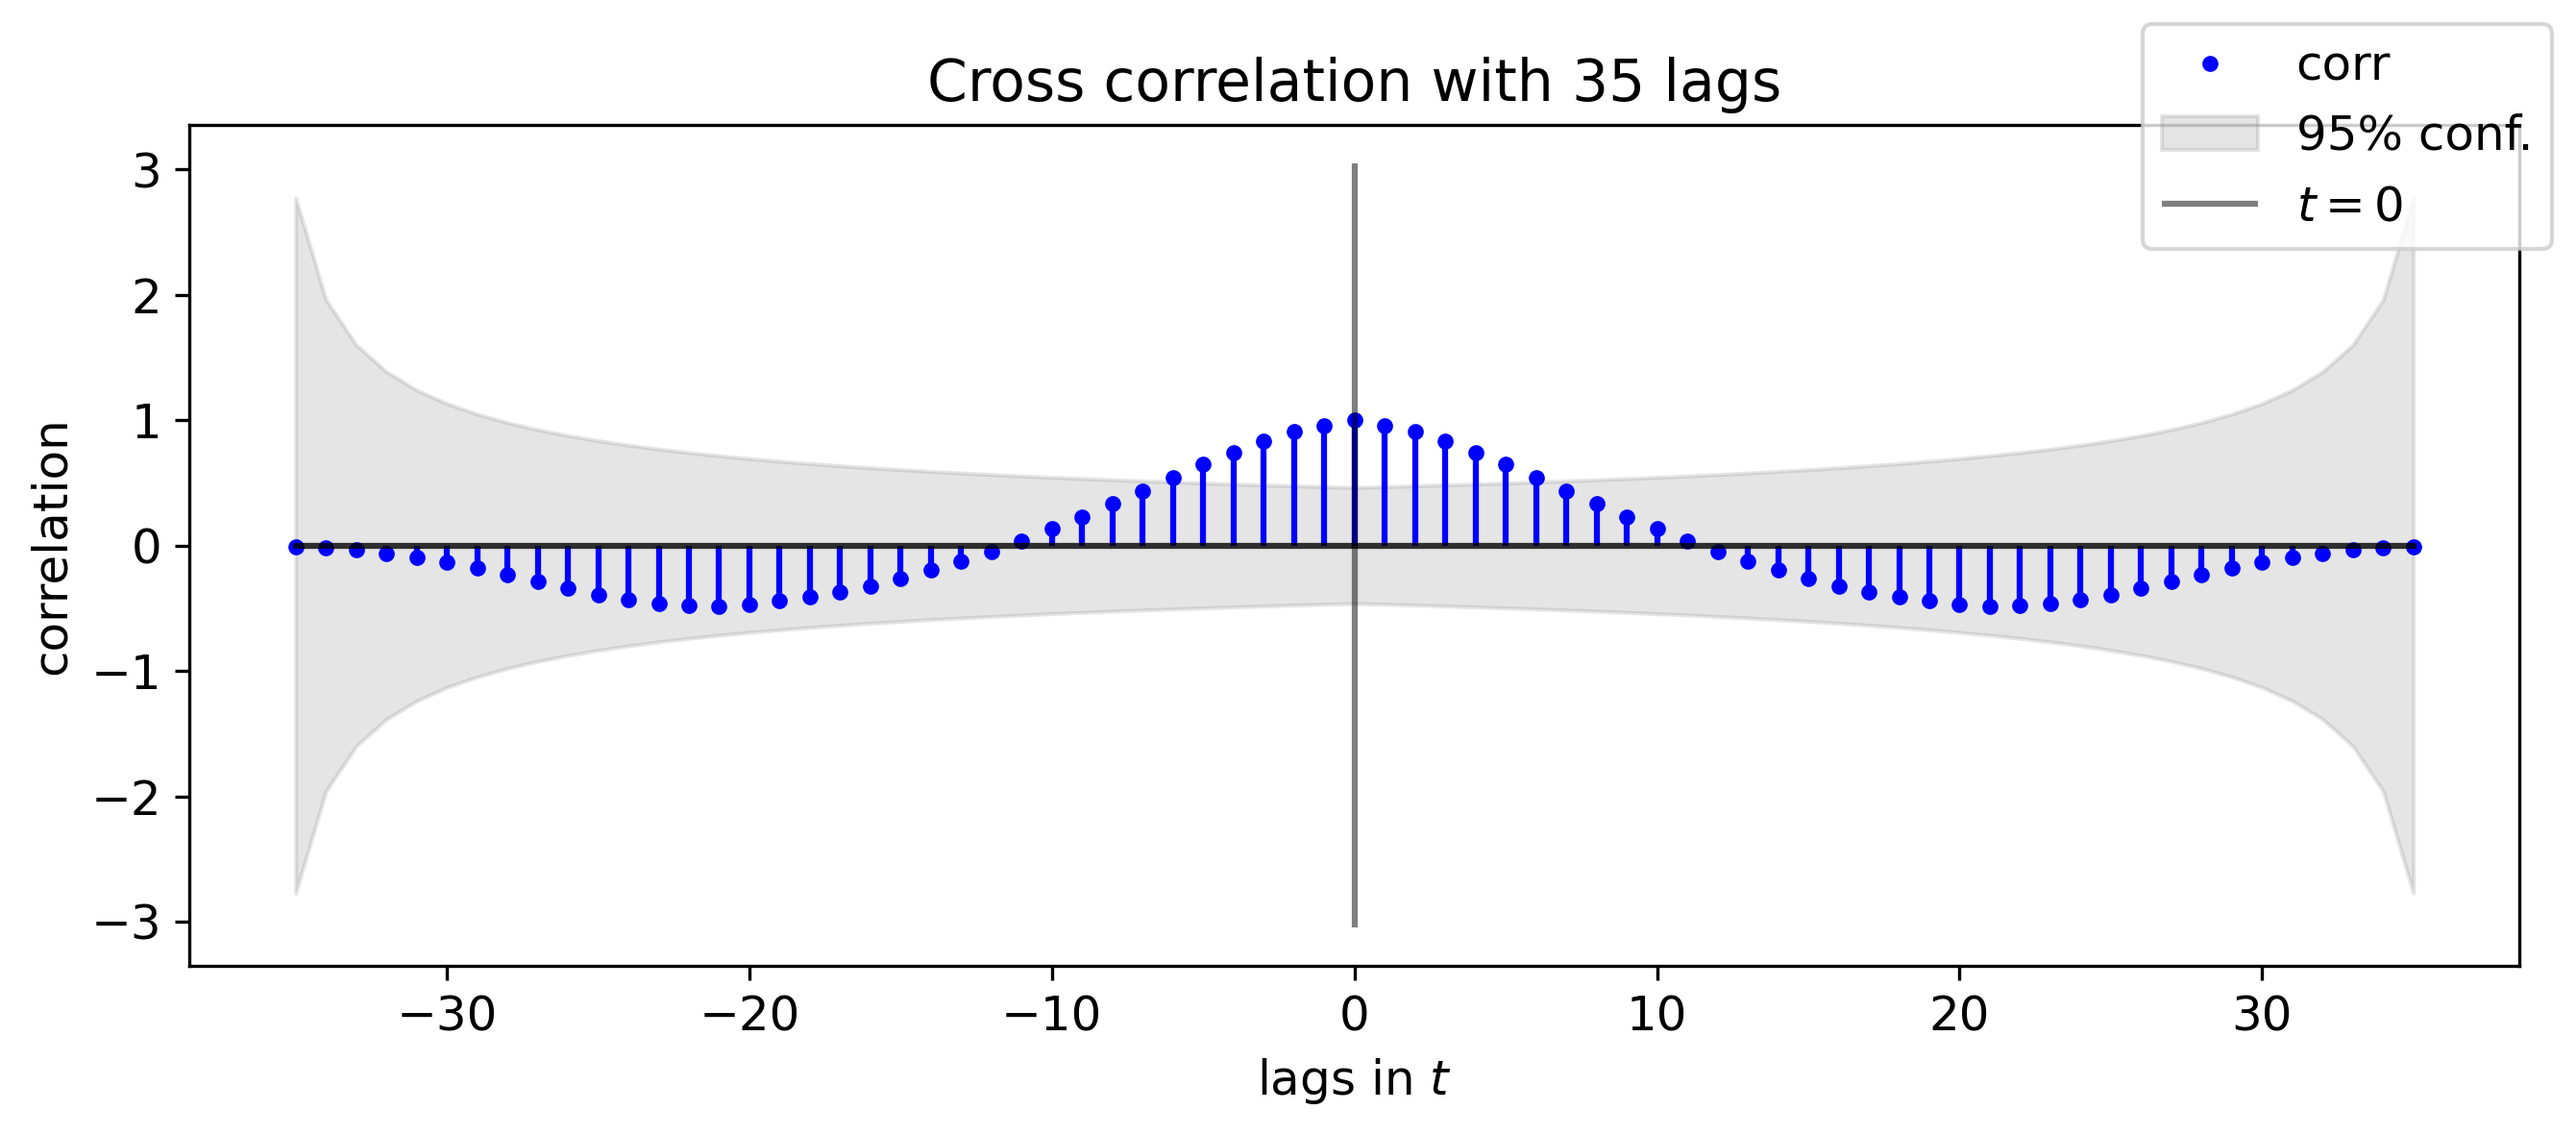

In [13]:
_, _, _, fig = xcorr(sub.pi_de_estimate_Y, dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_structural_acorr.png')

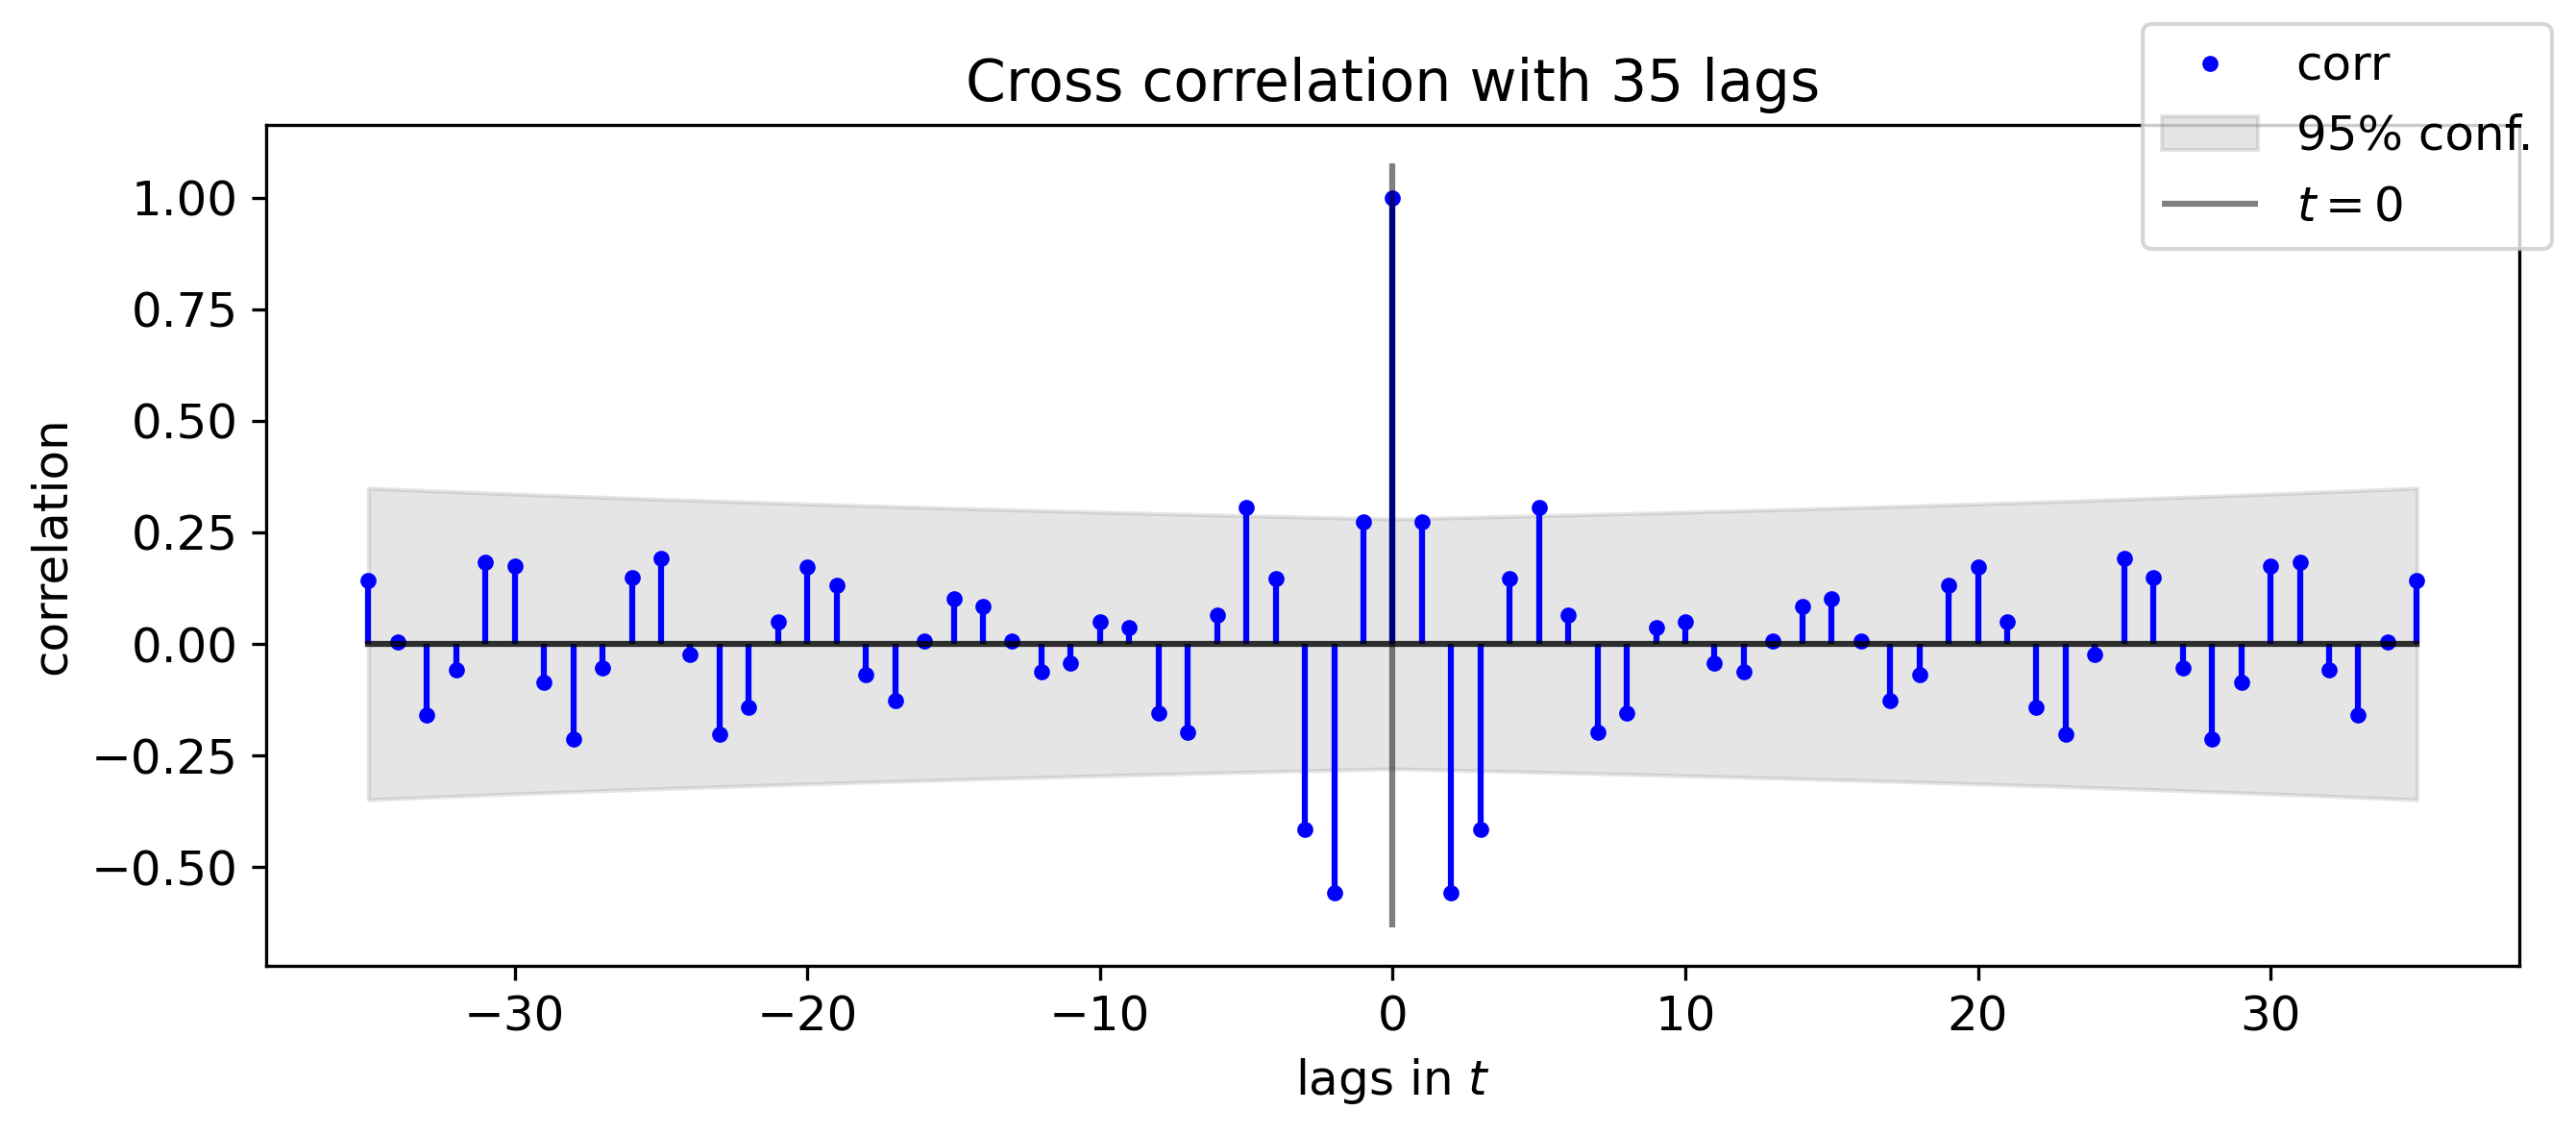

In [14]:
_, _, _, fig = xcorr(sub2.T_sum_ind_op_diff.dropna(), dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_T_sum_acorr.png')

## VECM

In [15]:
df_sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act',
                  'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_perc_MY_S_error_act', 'i_exp_WY',
                  'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum_ind_op', 'T_sum_ind_op_diff', 'T_sum_raw']
                 , 'M', 'last')
df_sub = pd_join_freq(df_sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
df_sub['pi_perc_MY_error_act'] /= 100
df_sub['delta_pe_MY_error_act_MY'] /= 10
t_sum_var = 'T_sum_ind_op'

### pi perc

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


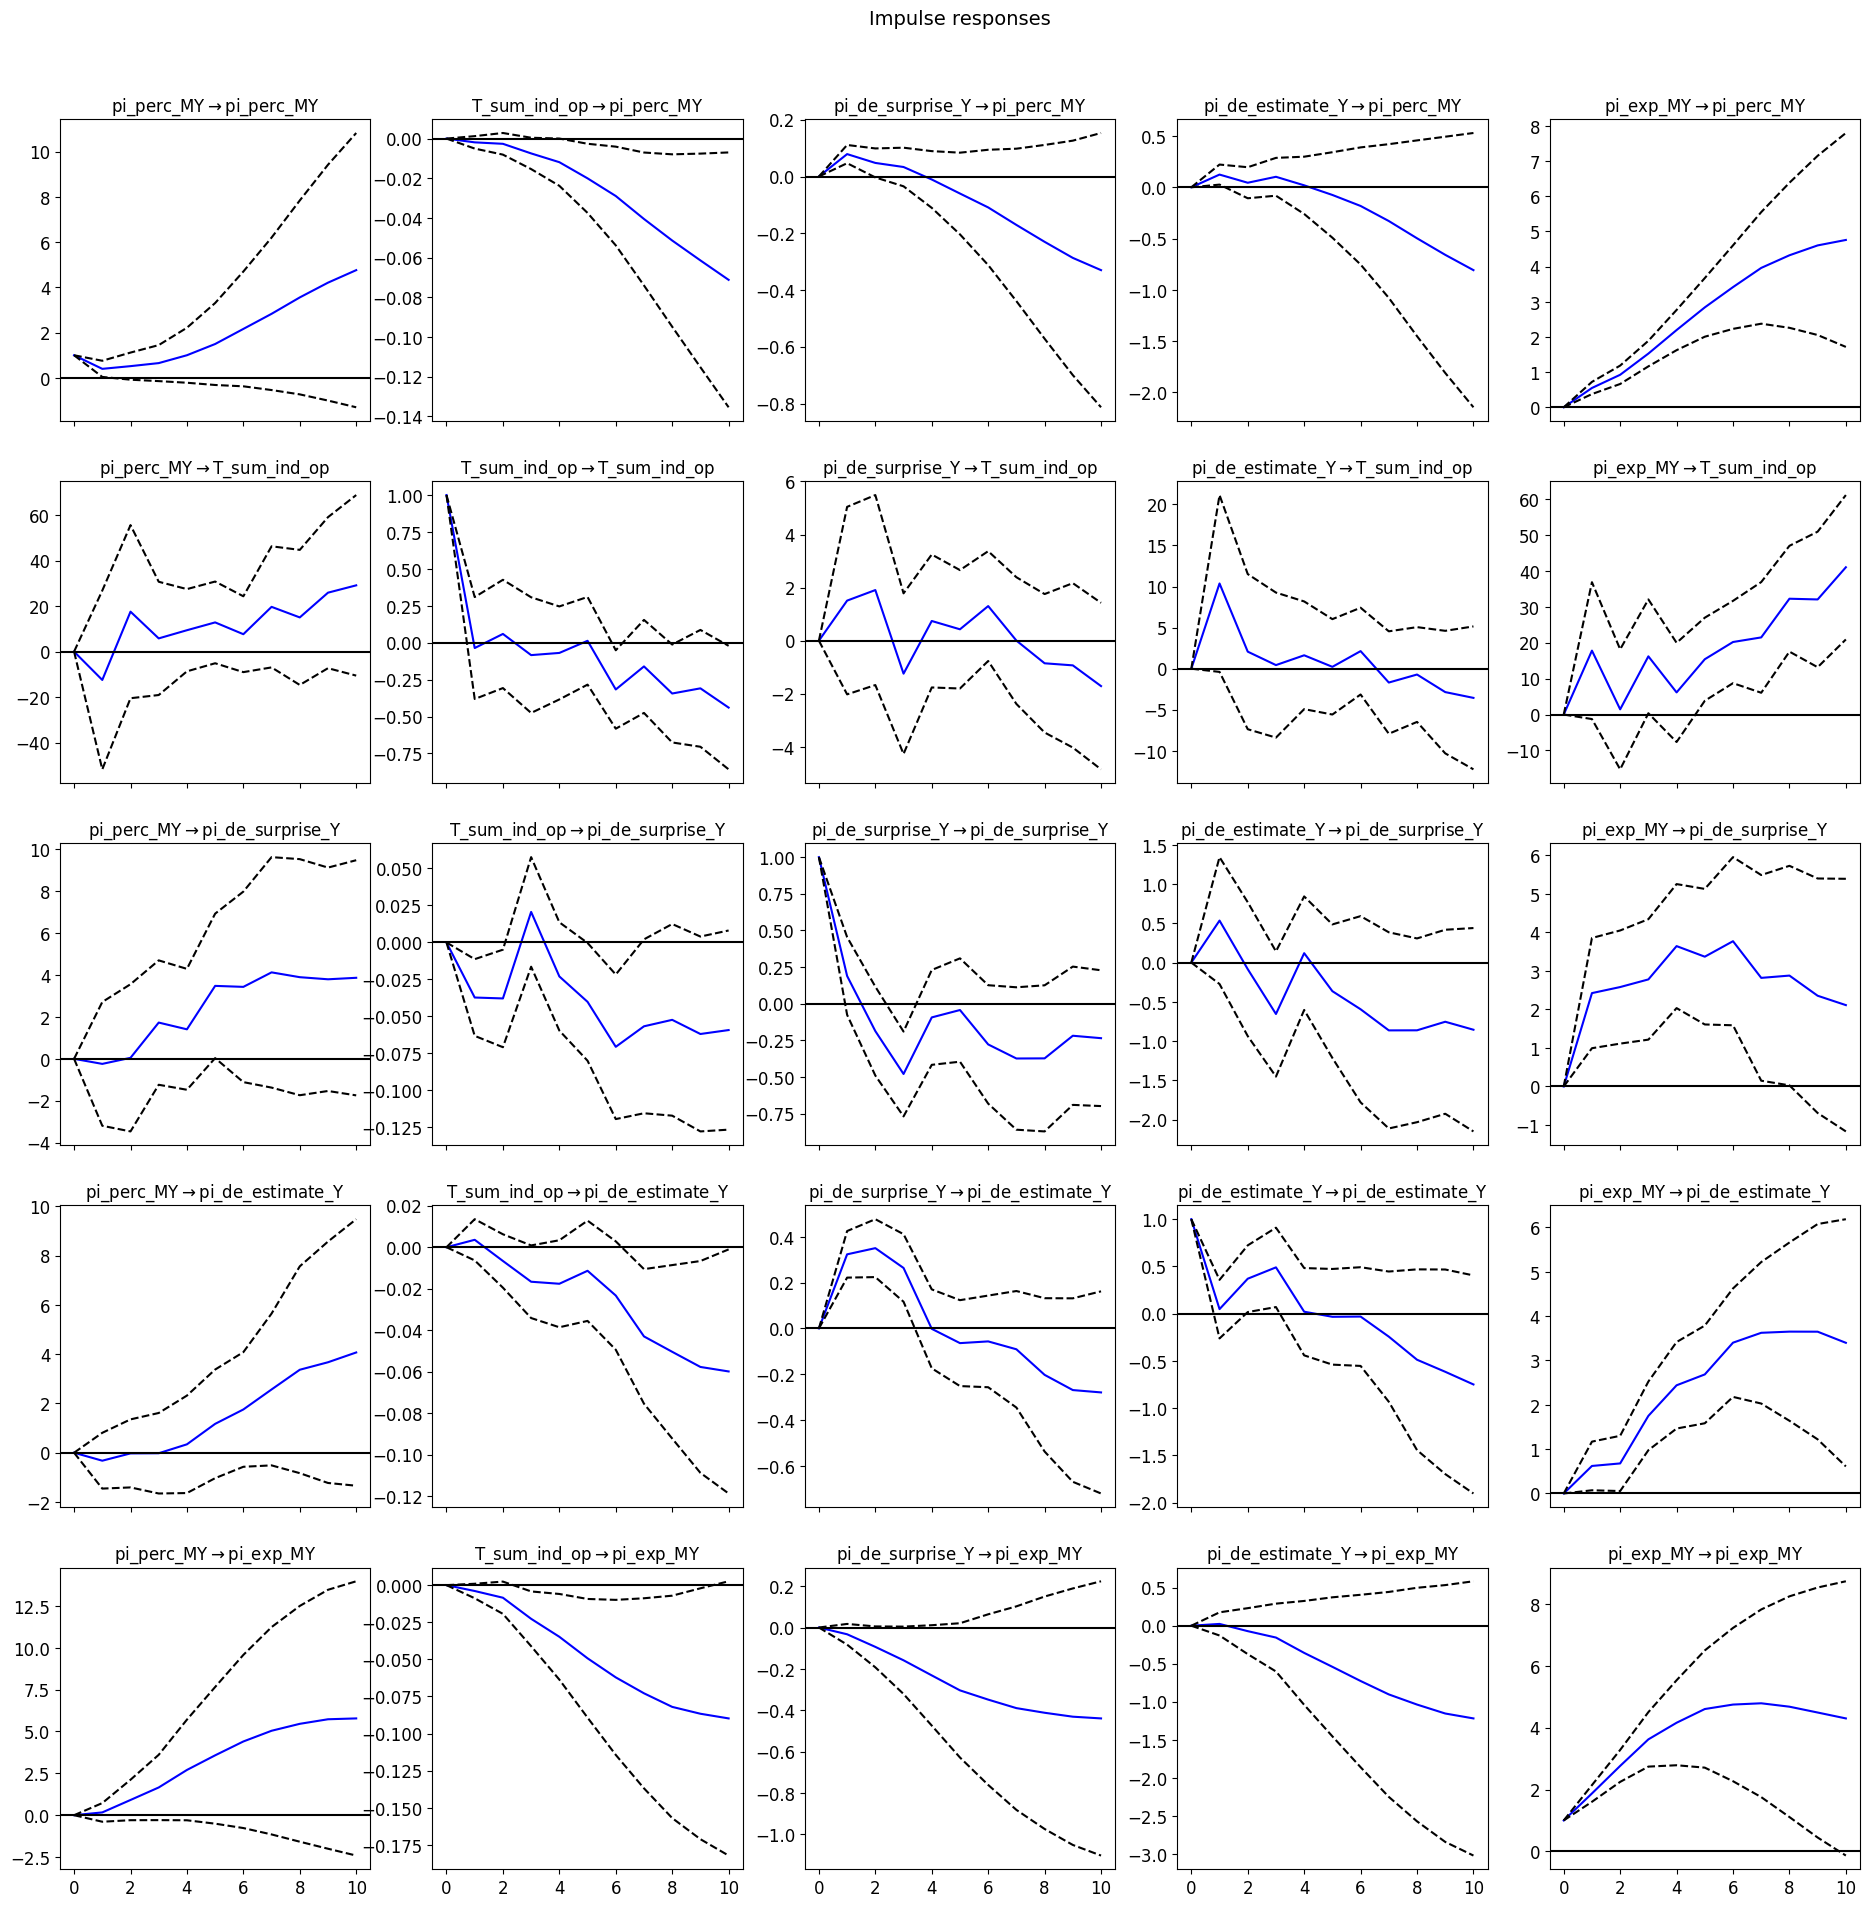

In [16]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5, deterministic='ci')
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm1.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc.png');

### pi perc error

pi_perc_MY_error_act ADF p-val: 1.974540165527414e-08
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
3 0


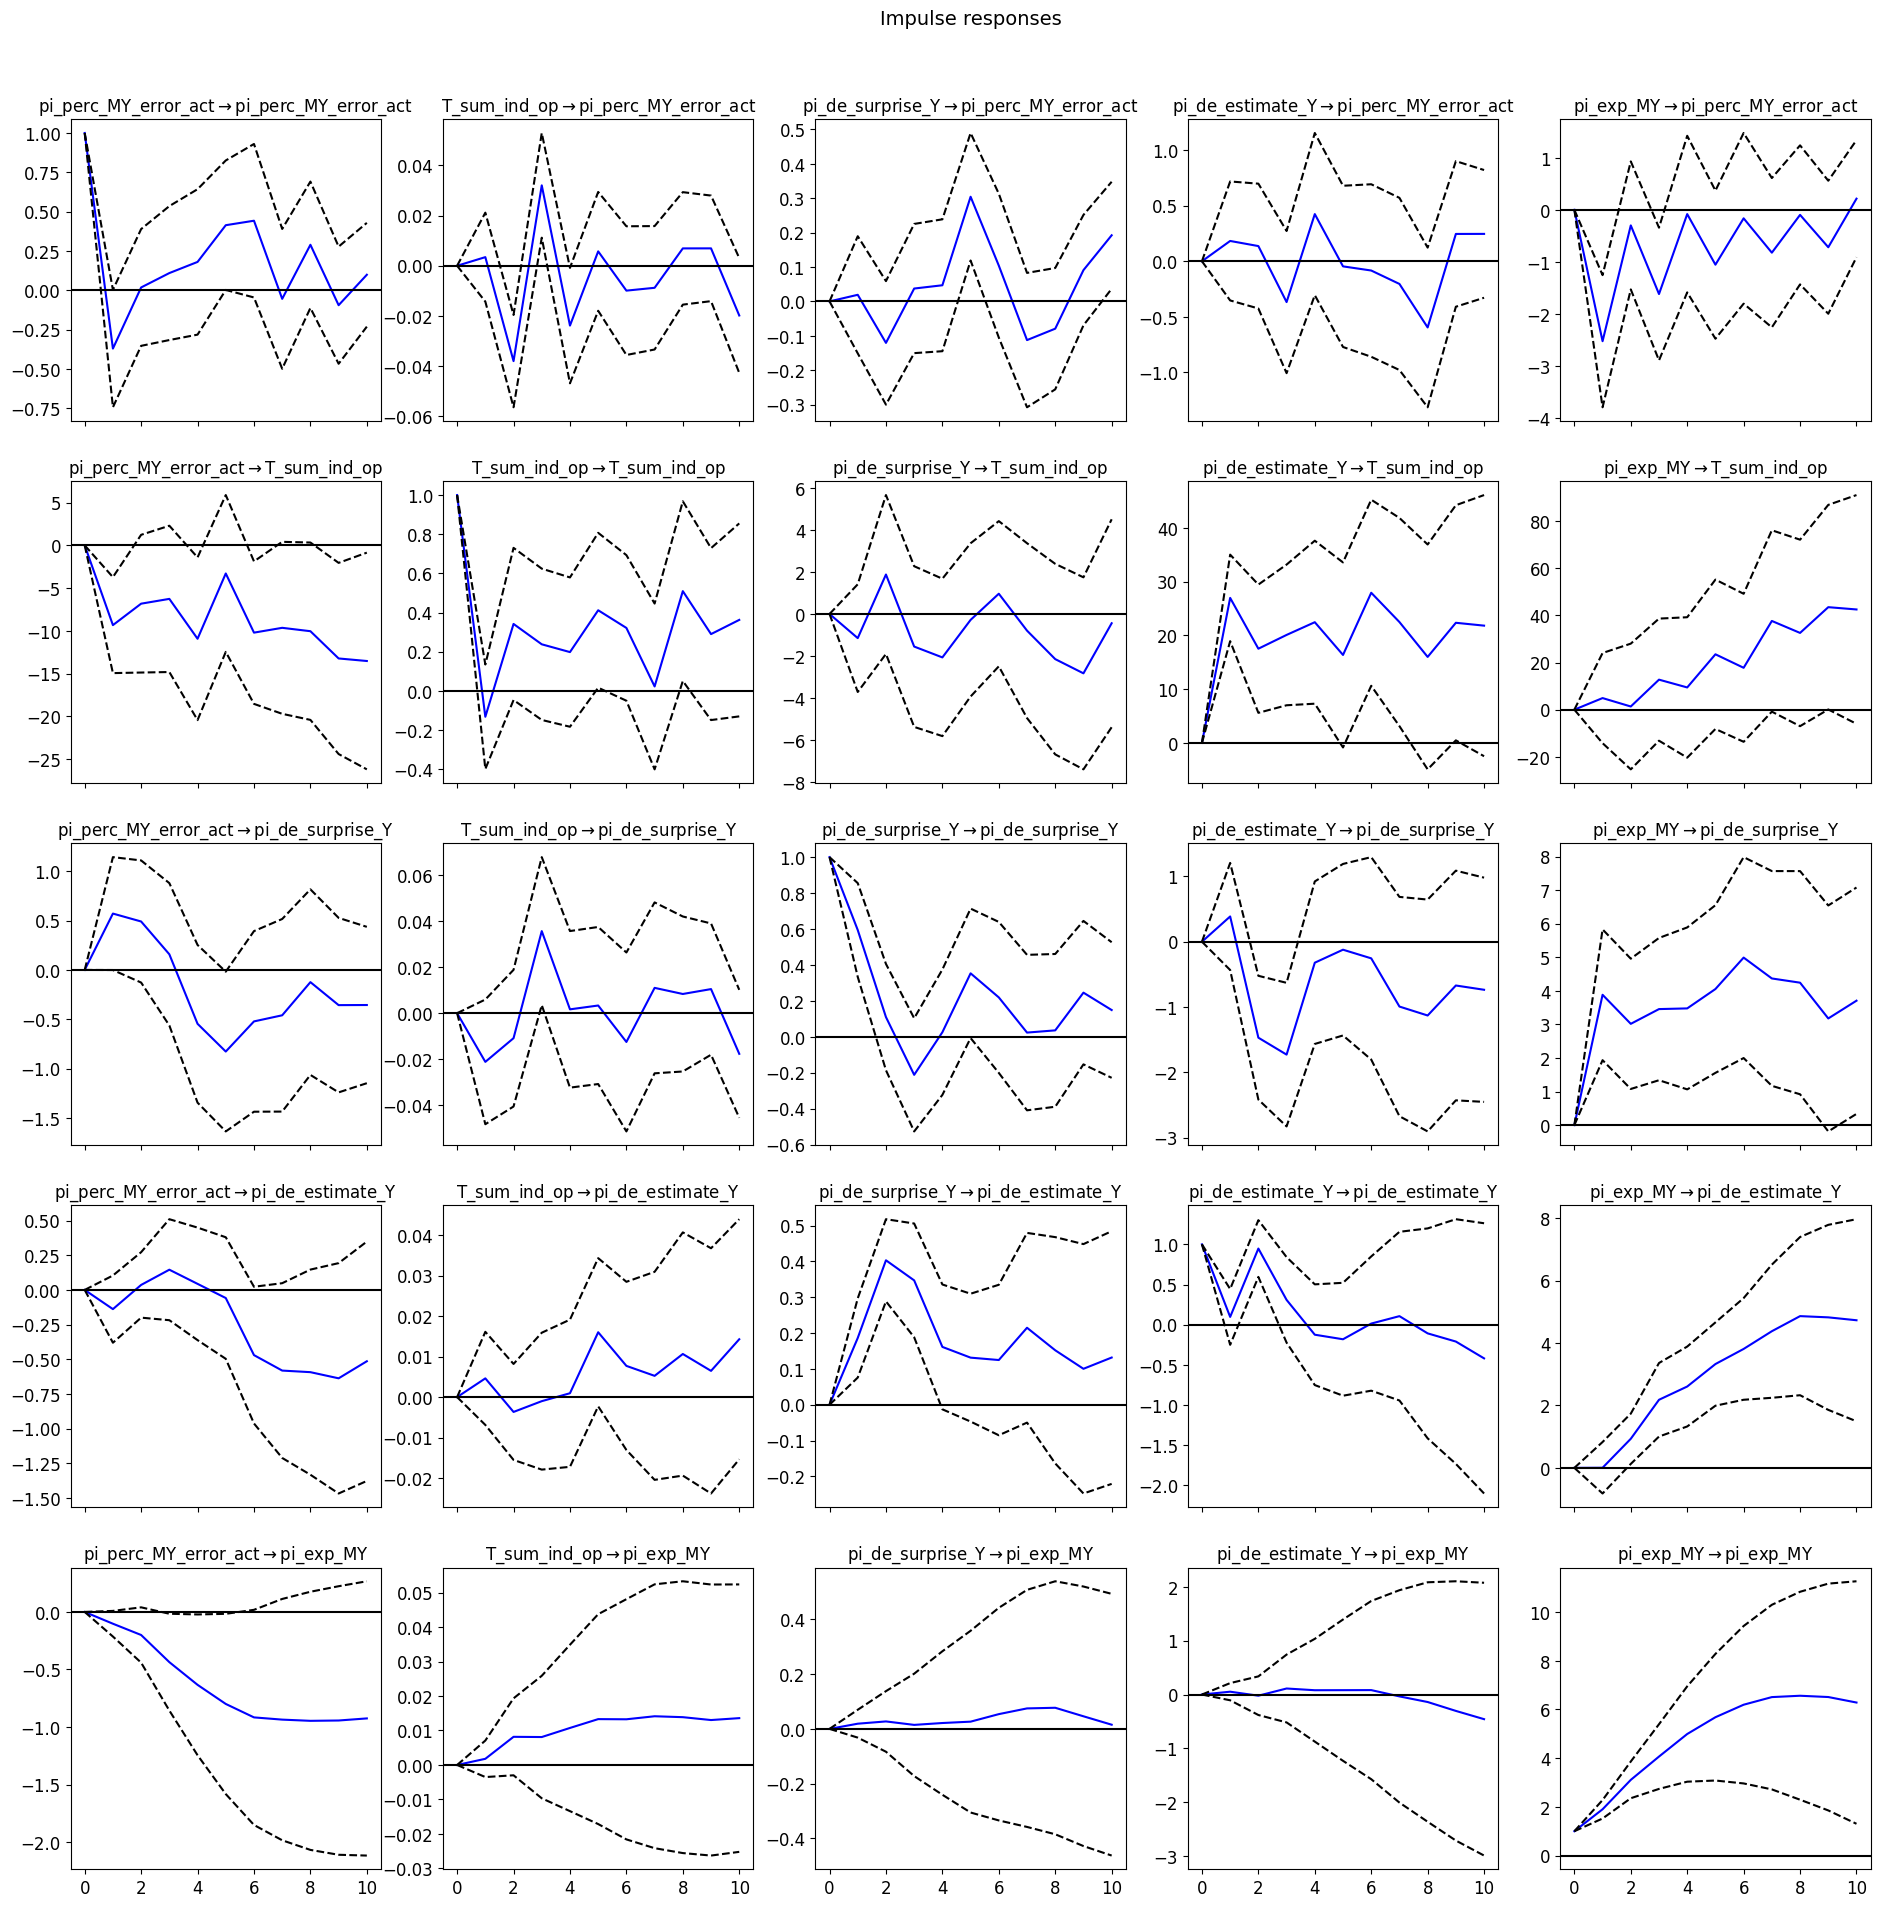

In [17]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm2.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc_resid.png');

### delta pe

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
5
3 1


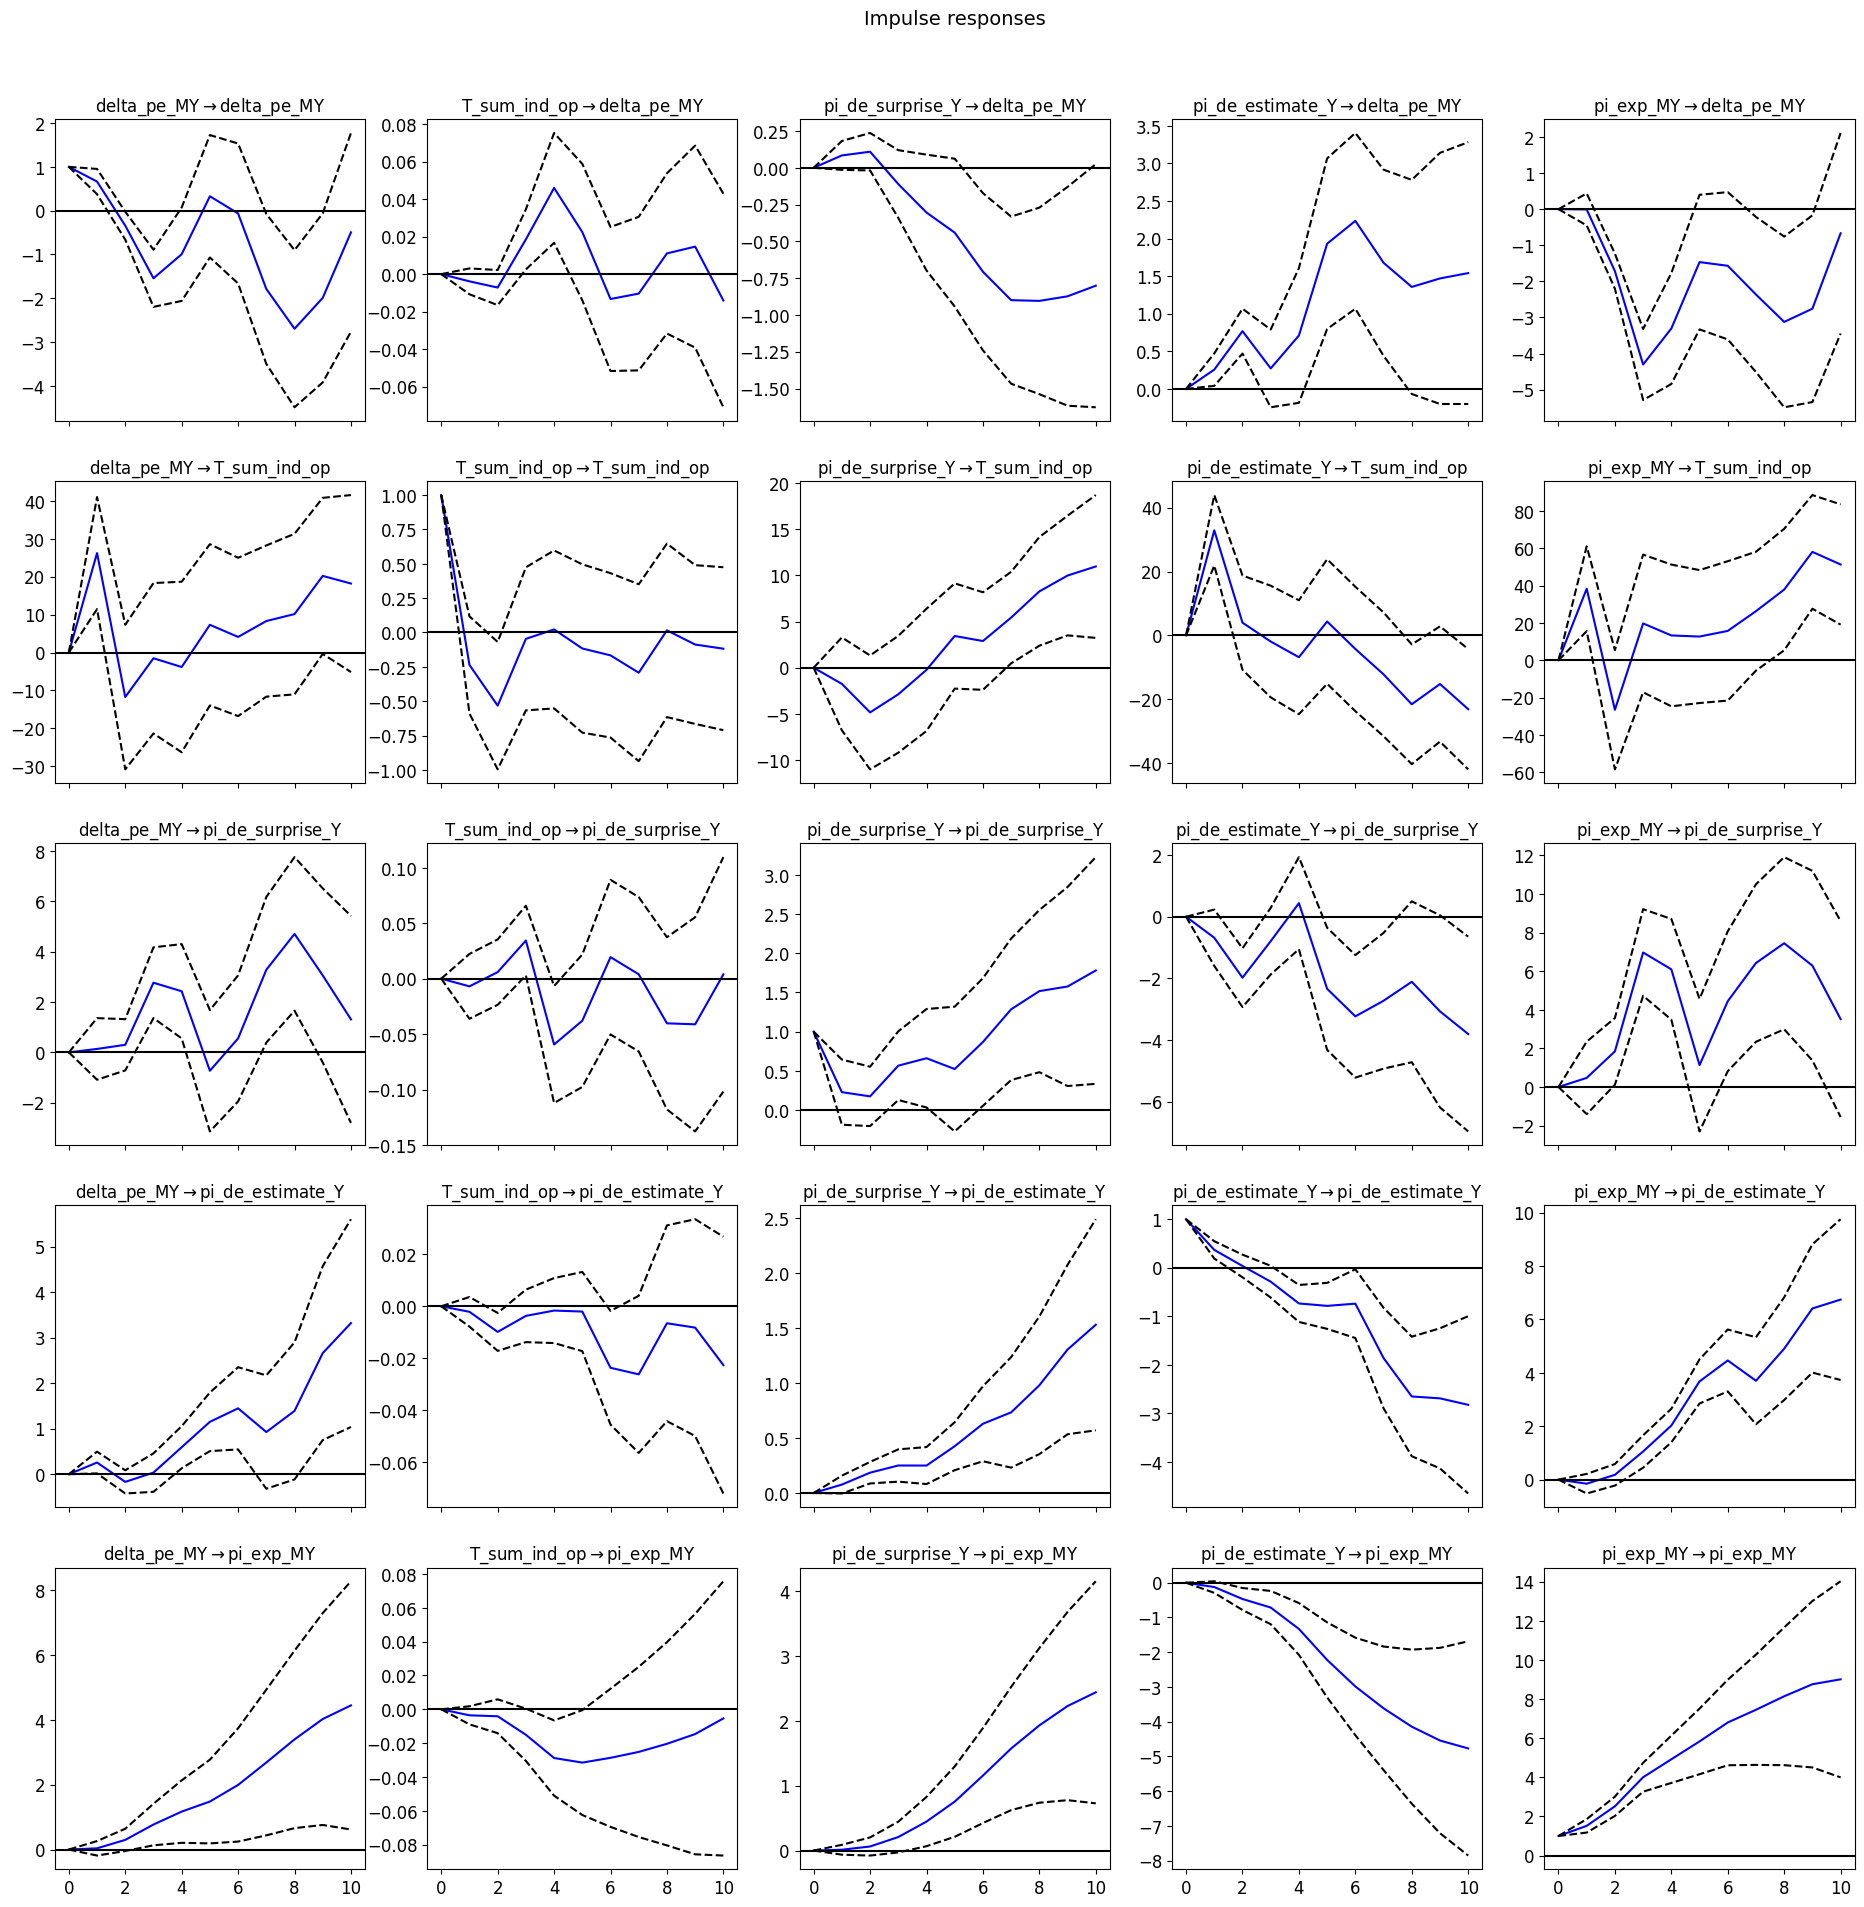

In [18]:
cols_endog, cols_exog = ['delta_pe_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm3.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_delta_pe.png');

### delta pe error

delta_pe_MY_error_act_MY ADF p-val: 0.5446227785790462
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
2 0


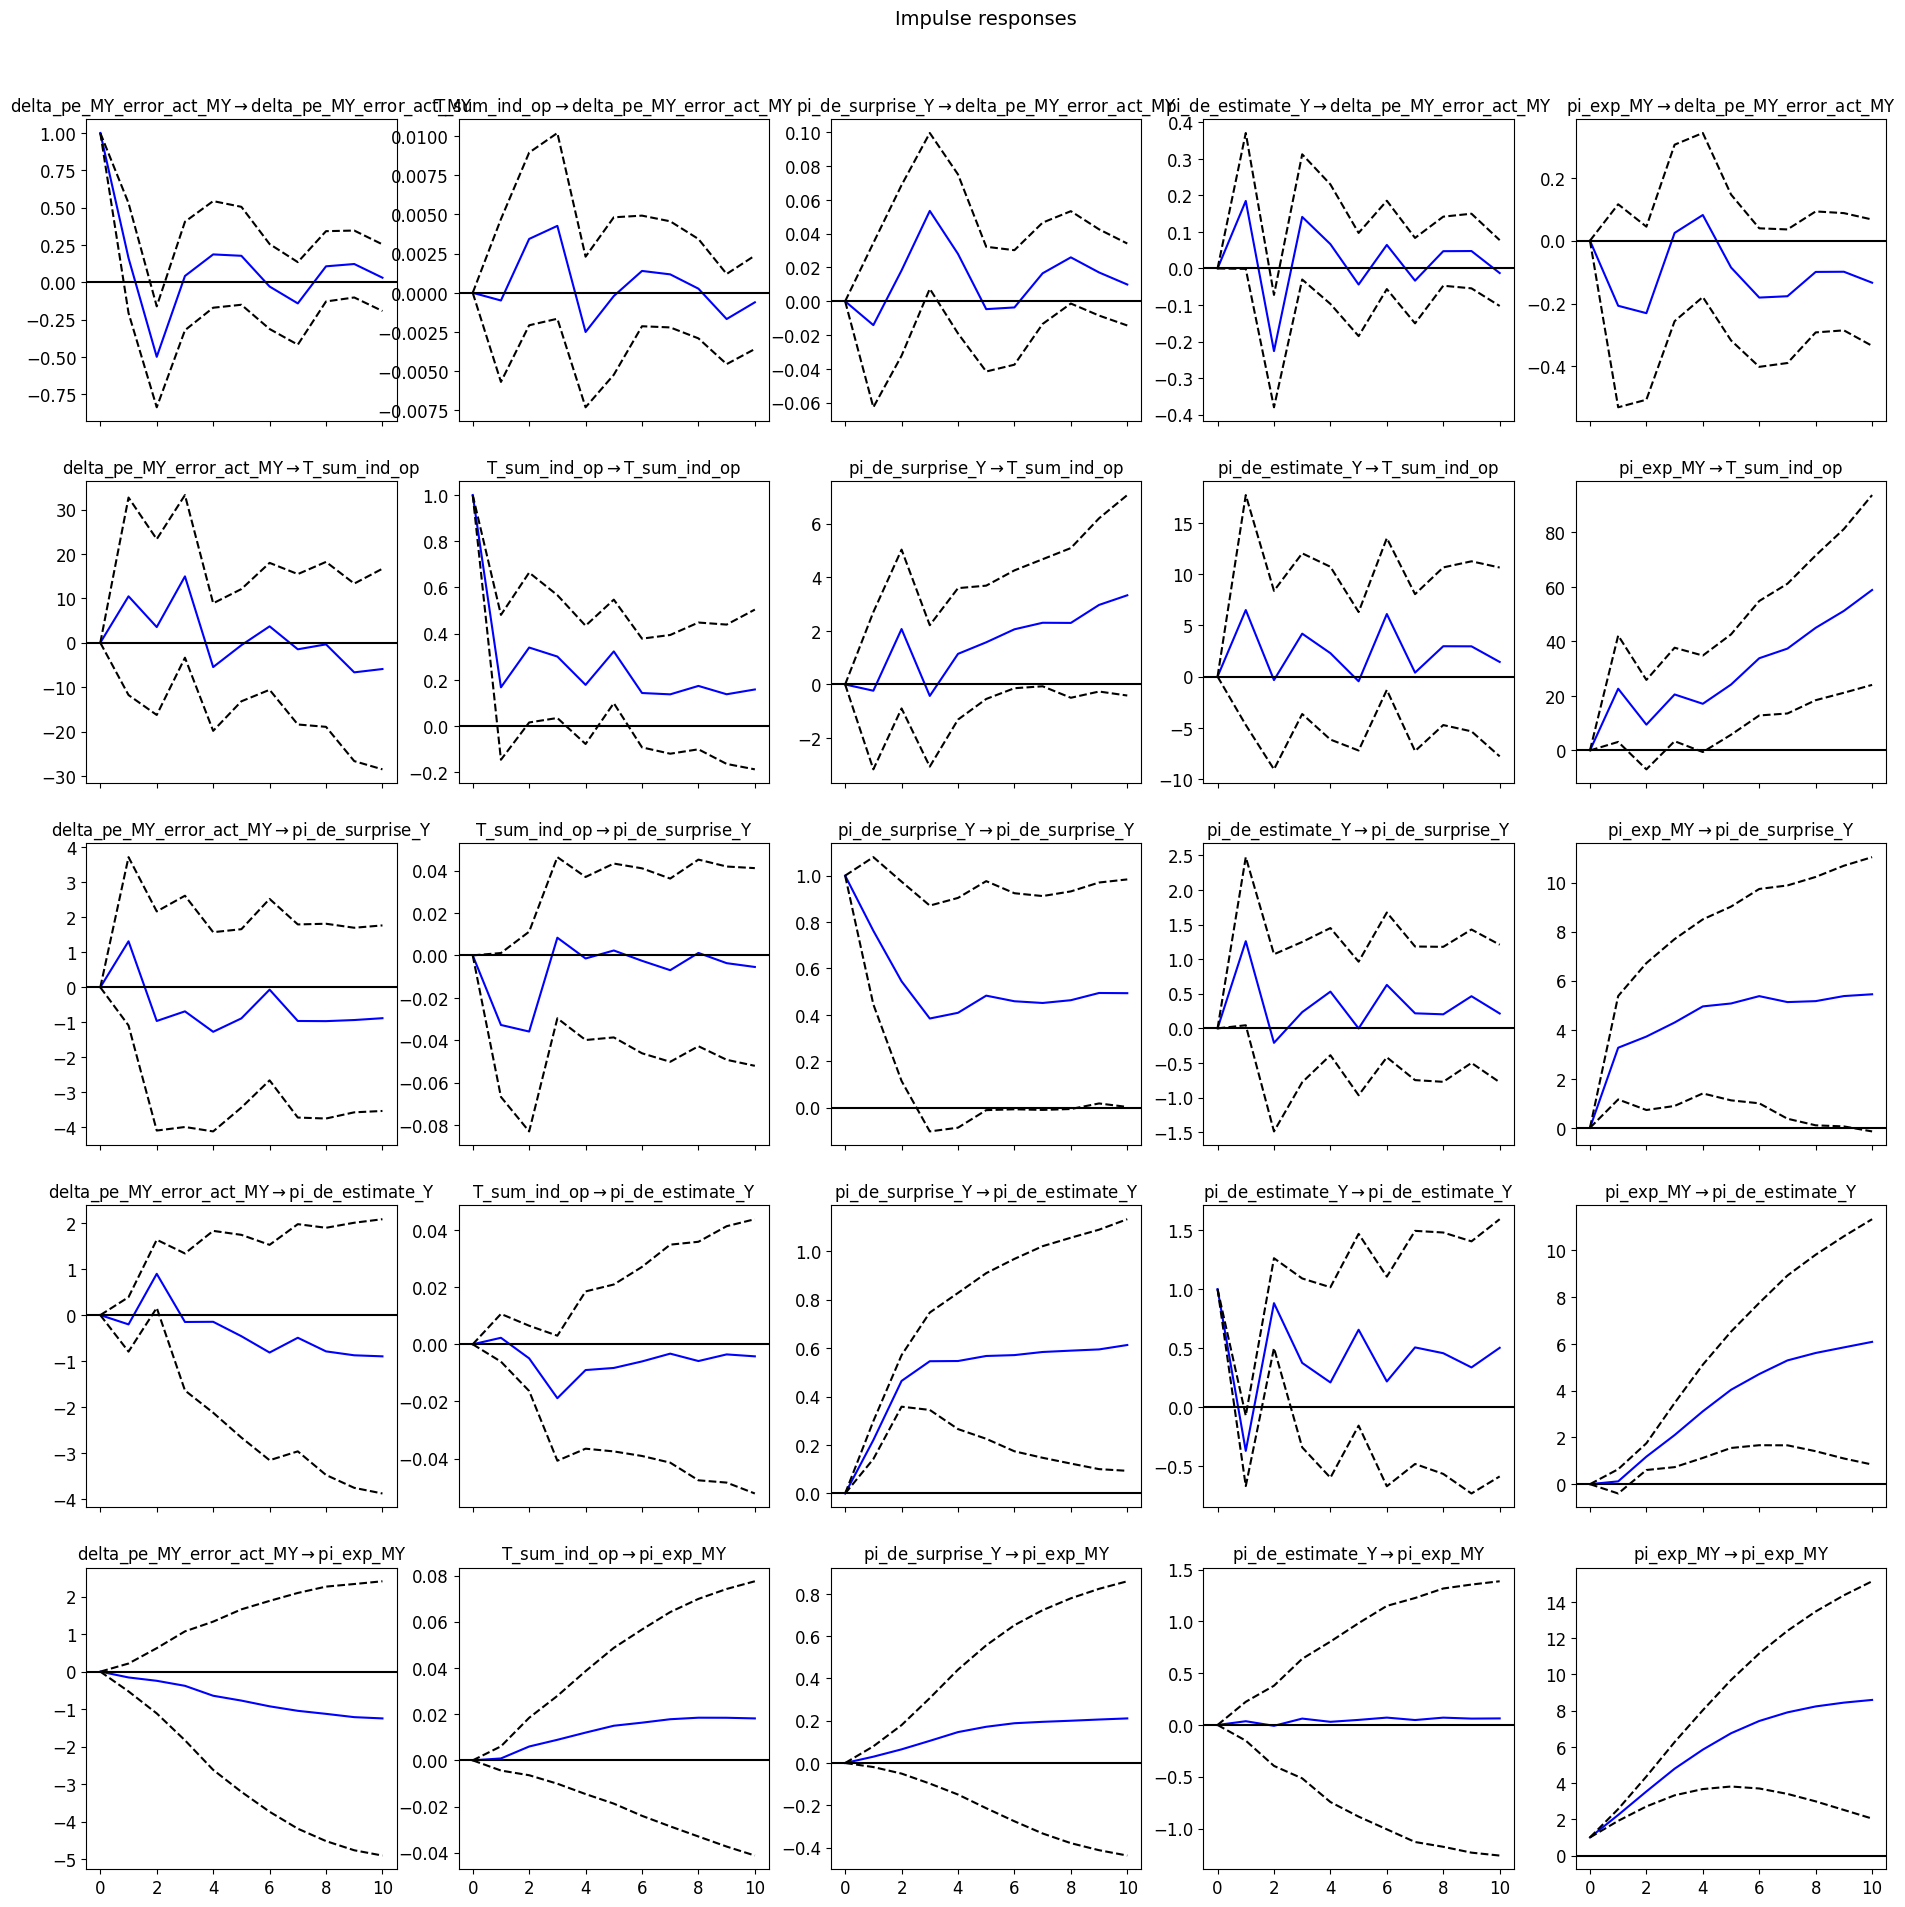

In [19]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm4.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_delta_pe_resid.png');

### pi perc S

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y_lead1 ADF p-val: 0.24946359680678376
pi_de_estimate_Y_lead1 ADF p-val: 0.7867507163884697
pi_exp_MY ADF p-val: 0.14479079097337977
4
3 3


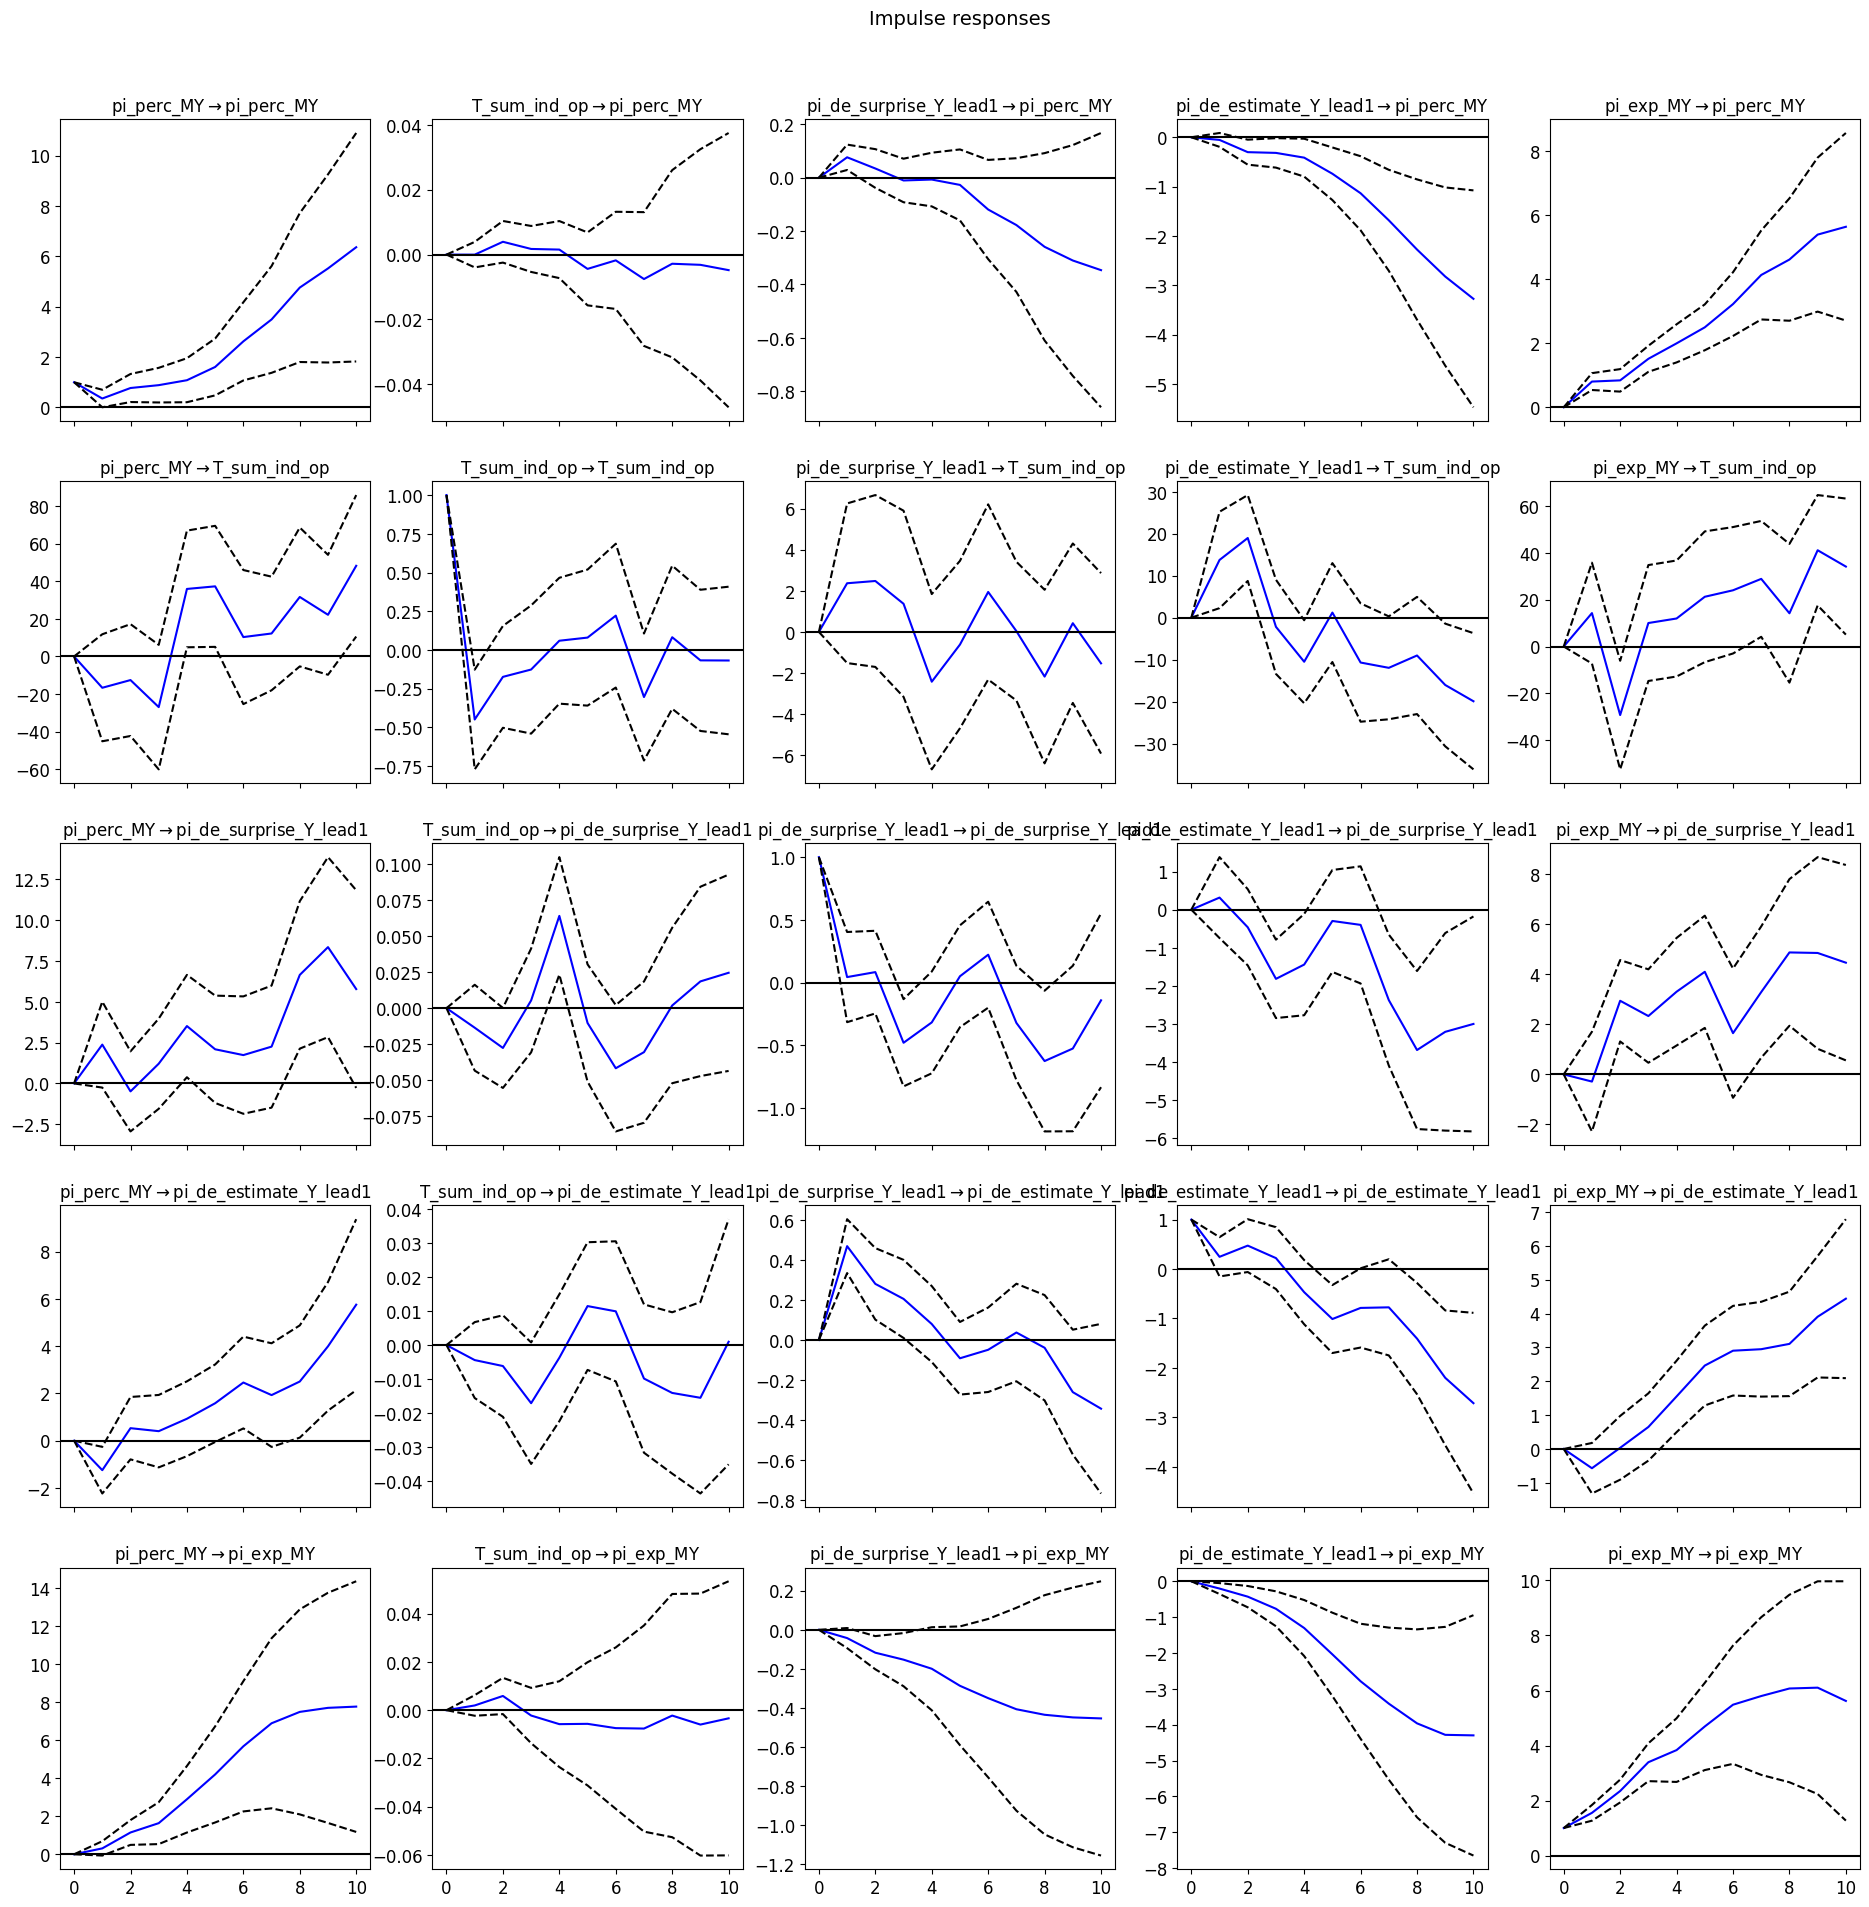

In [20]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY', ]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm5.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_percS.png');

### pi error S

pi_perc_MY_S_error_act ADF p-val: 5.314272487890989e-05
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y_lead1 ADF p-val: 0.40575633837933295
pi_de_estimate_Y_lead1 ADF p-val: 0.8003606318626139
pi_exp_MY ADF p-val: 0.2551156035612694
4
2 0


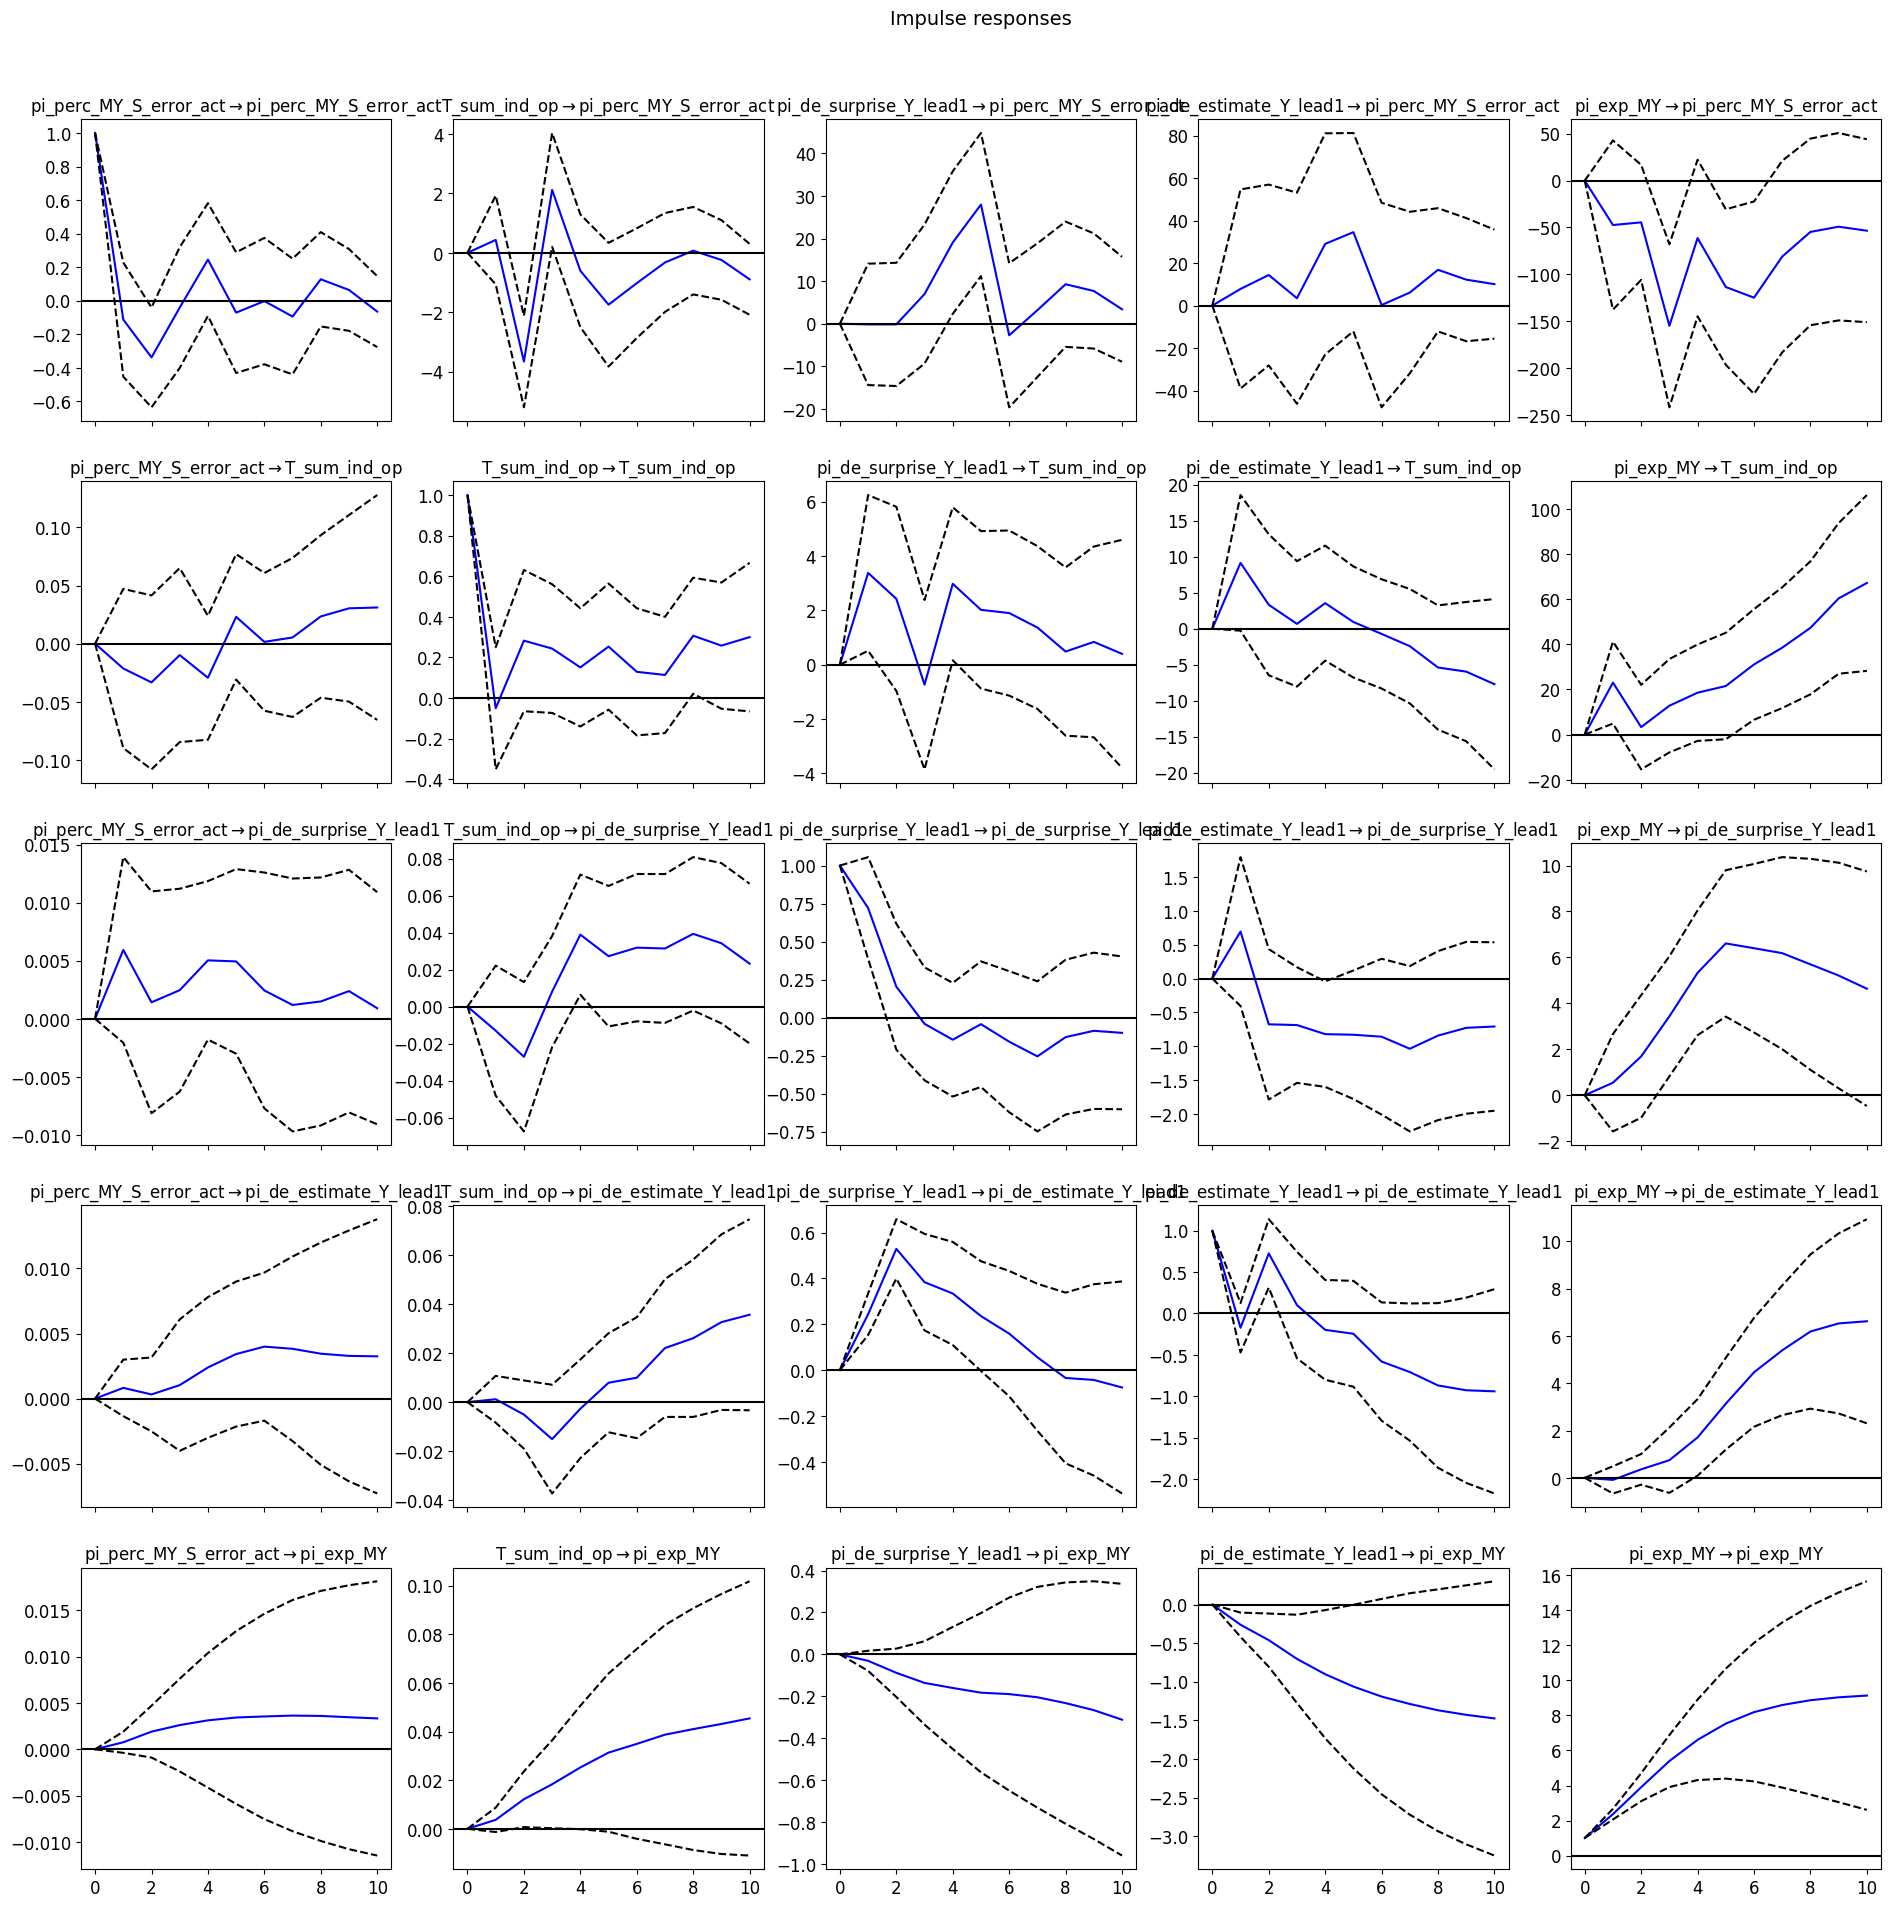

In [21]:
cols_endog, cols_exog = ['pi_perc_MY_S_error_act'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm6 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
save_fig(vecm6.irf().plot(figsize=(20,20)), 'fig_emp_macro_vecm_pi_perc_residS.png');

### summary

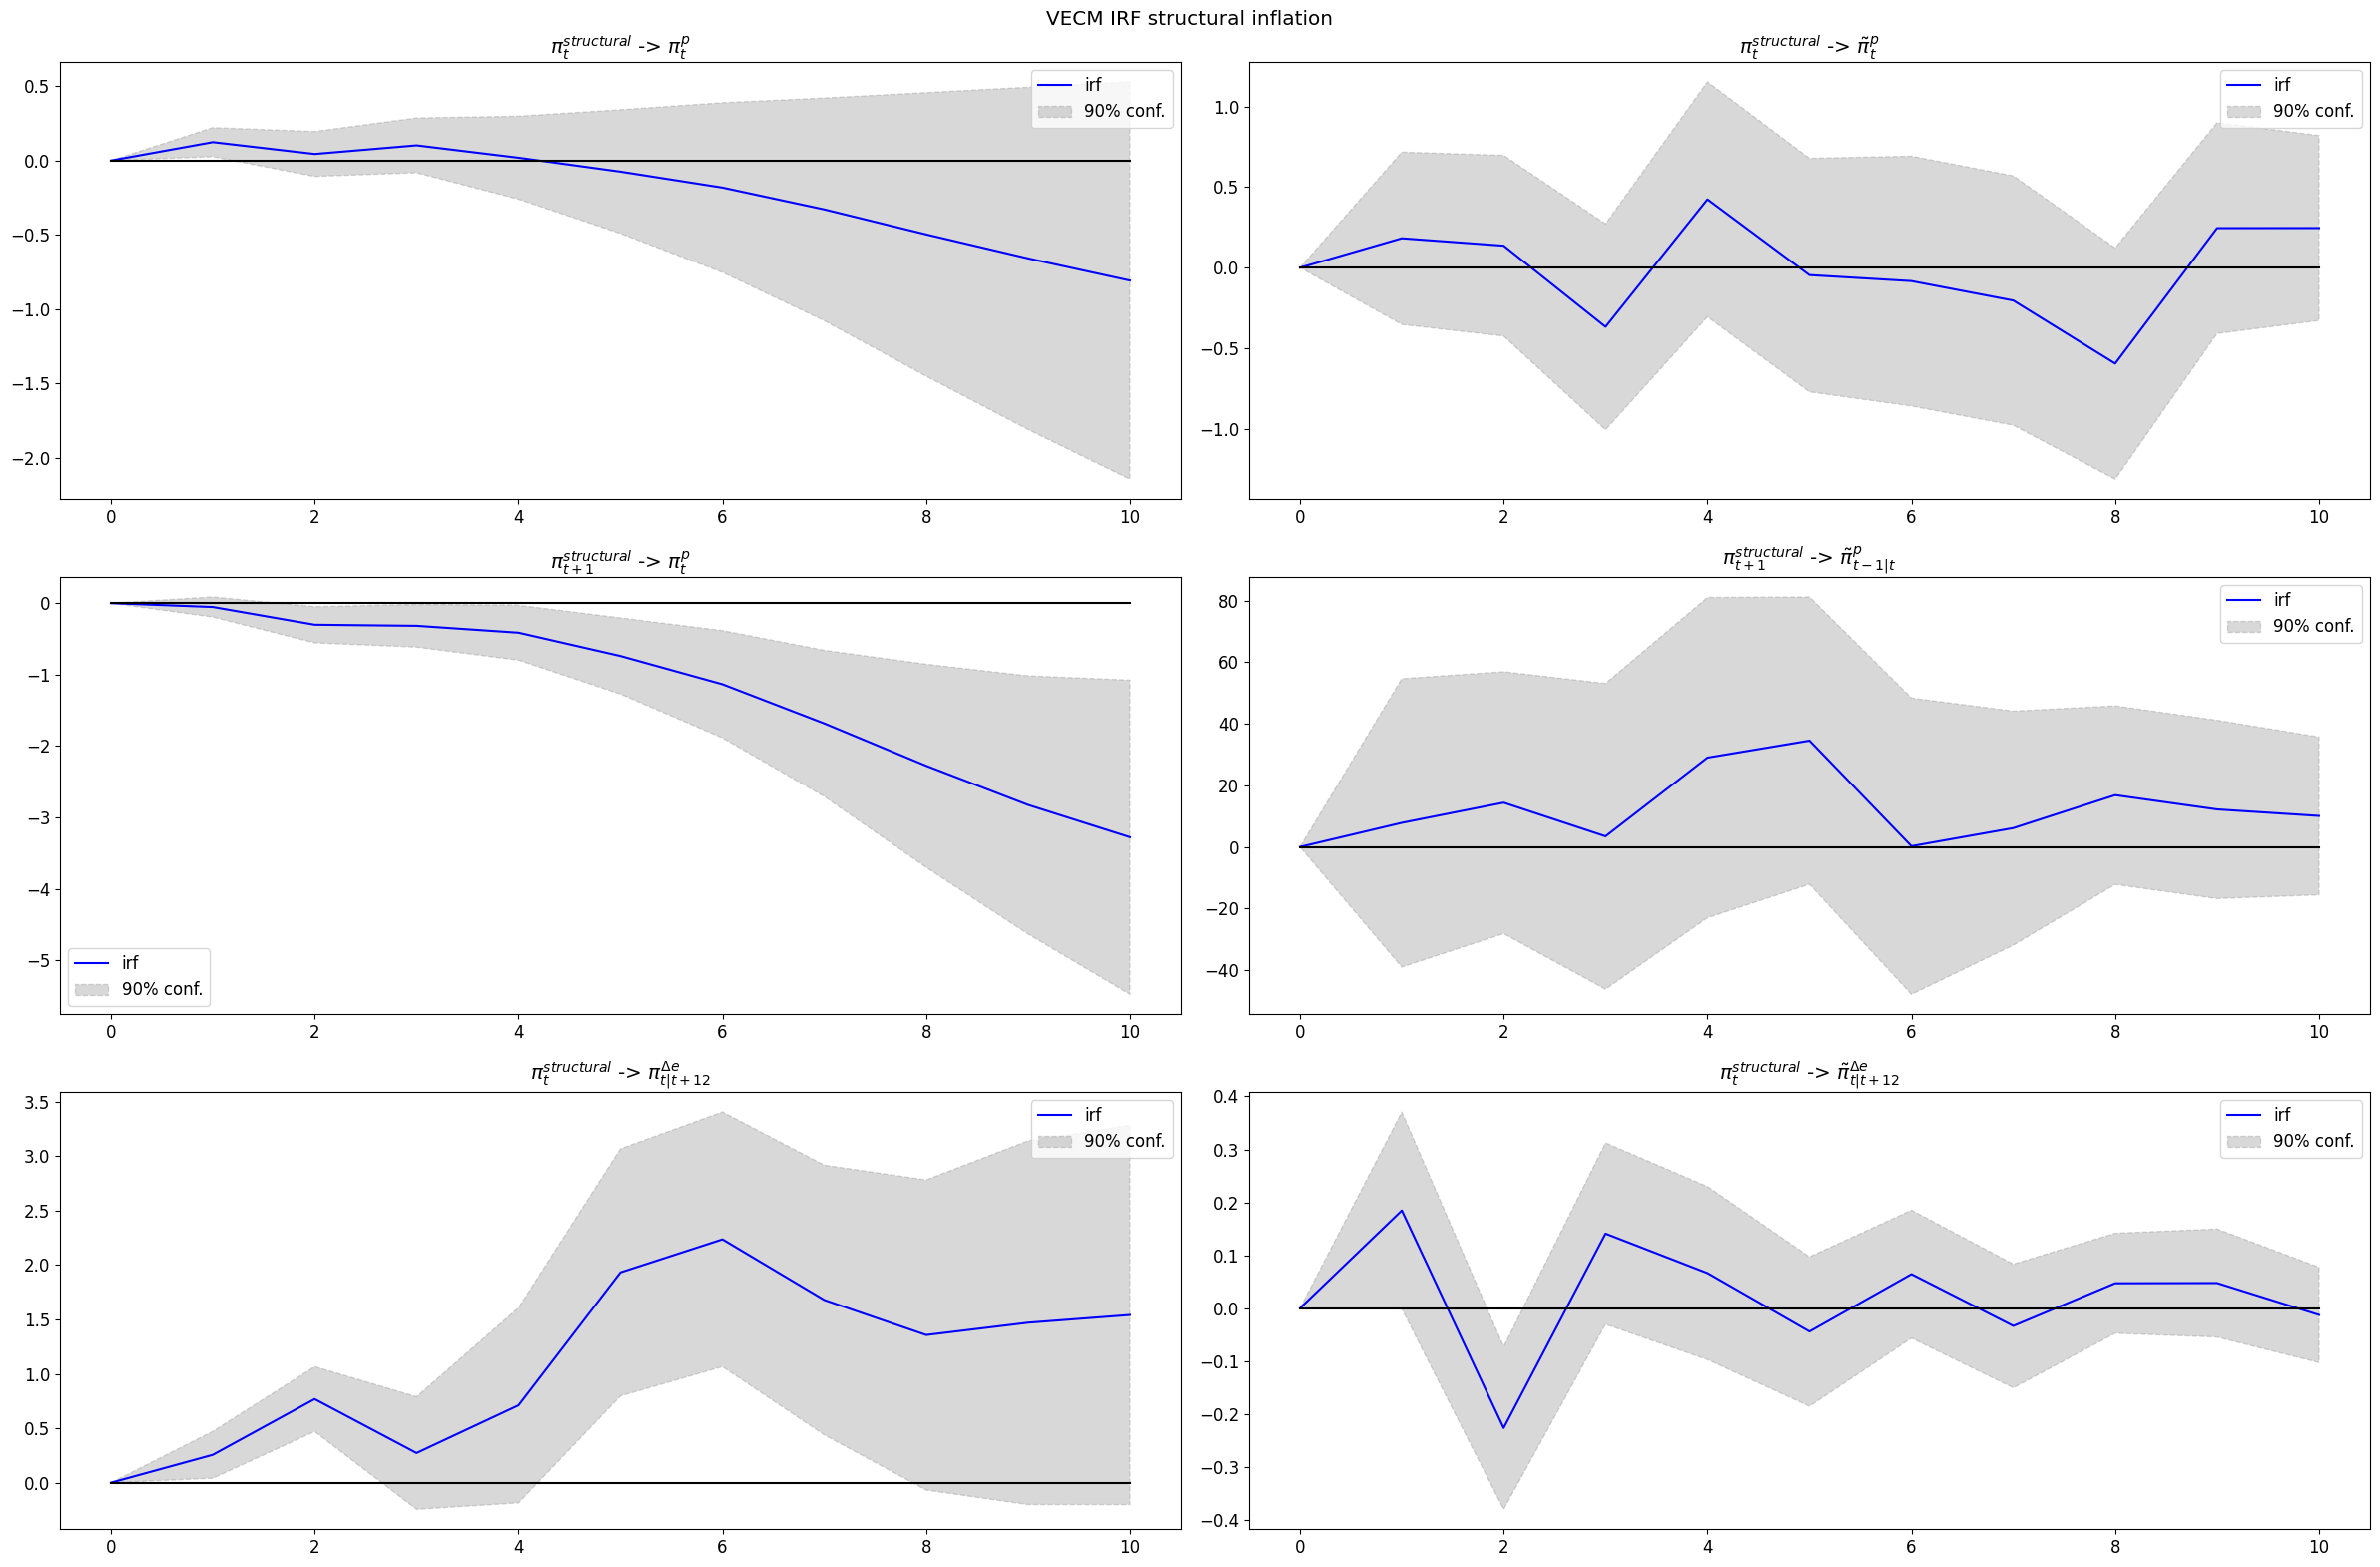

In [78]:
lst_vecms = [vecm1, vecm2, vecm5, vecm6, vecm3, vecm4]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_de_estimate_Y": "$\pi^{structural}_t$",
                                          "pi_de_estimate_Y_lead1": "$\pi^{structural}_{t+1}$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t-1|t}$",
                                         },
                             idx_vecm=(0, 3),
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF structural inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_struct.png")

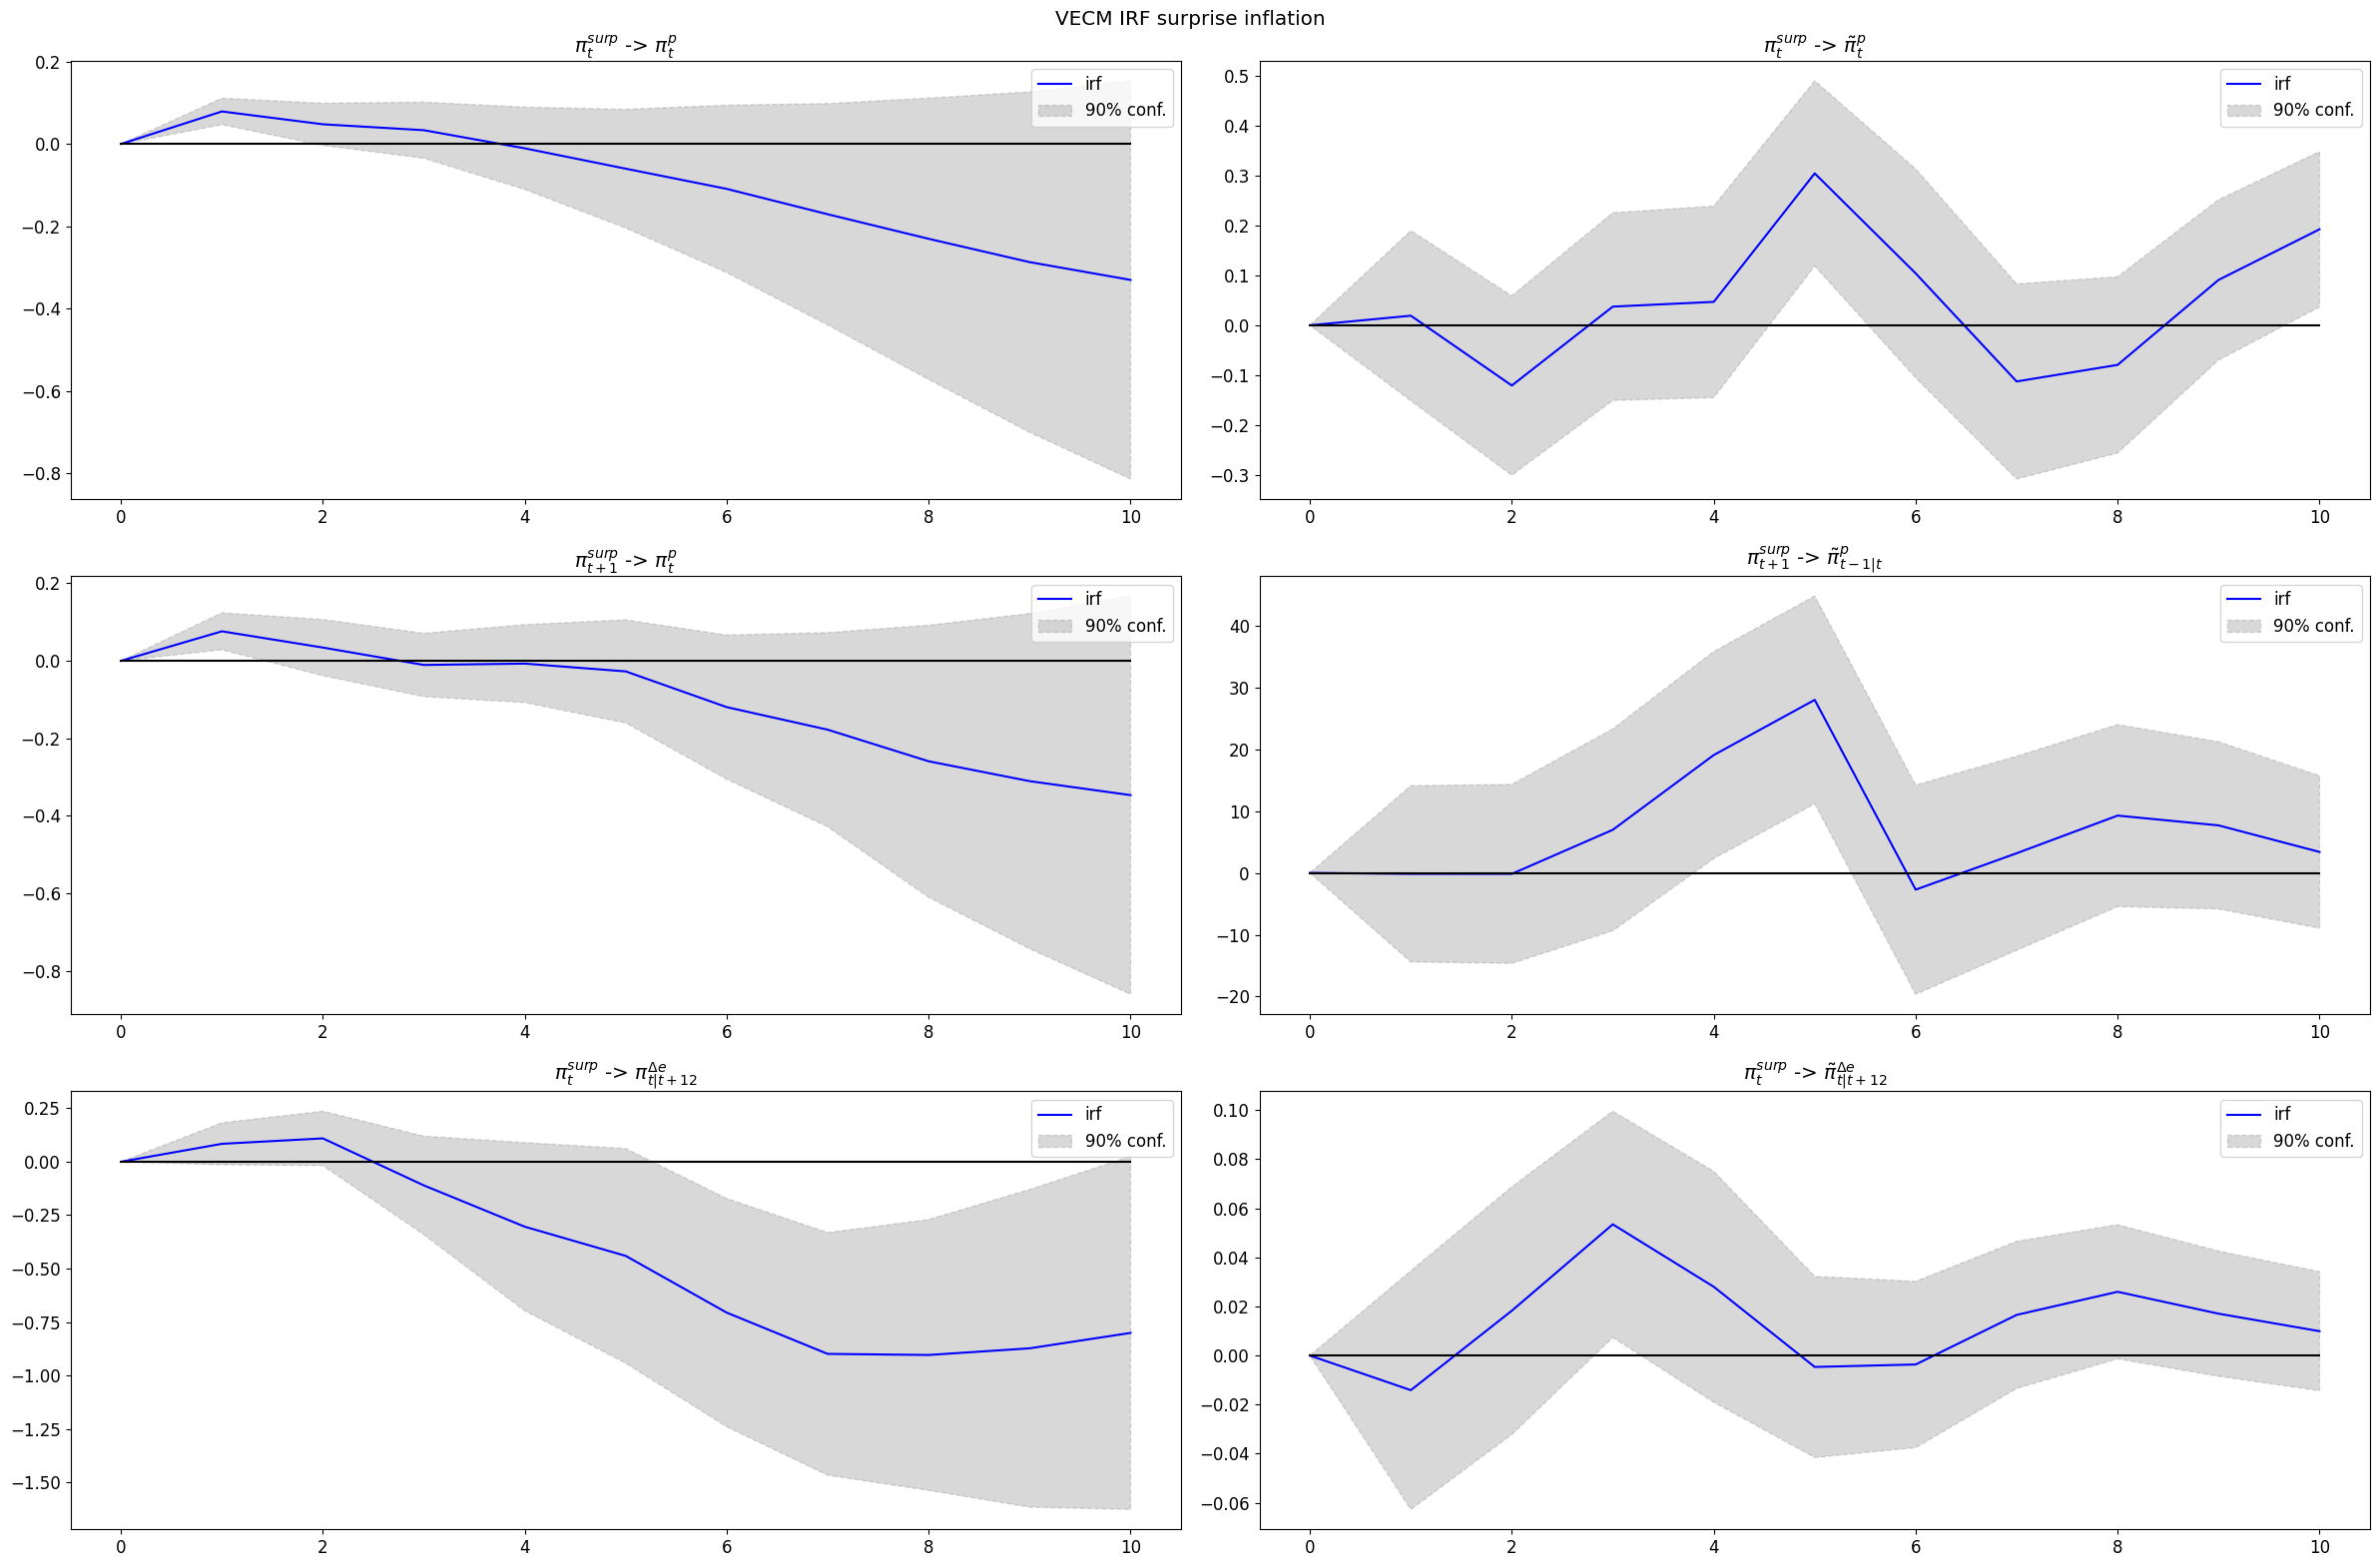

In [79]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "pi_de_surprise_Y_lead1": "$\pi^{surp}_{t+1}$",
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t-1|t}$",
                                         },
                             idx_vecm=(0,2),
                             n_cols=2, 
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_surp.png", GRAPHS_DIR)

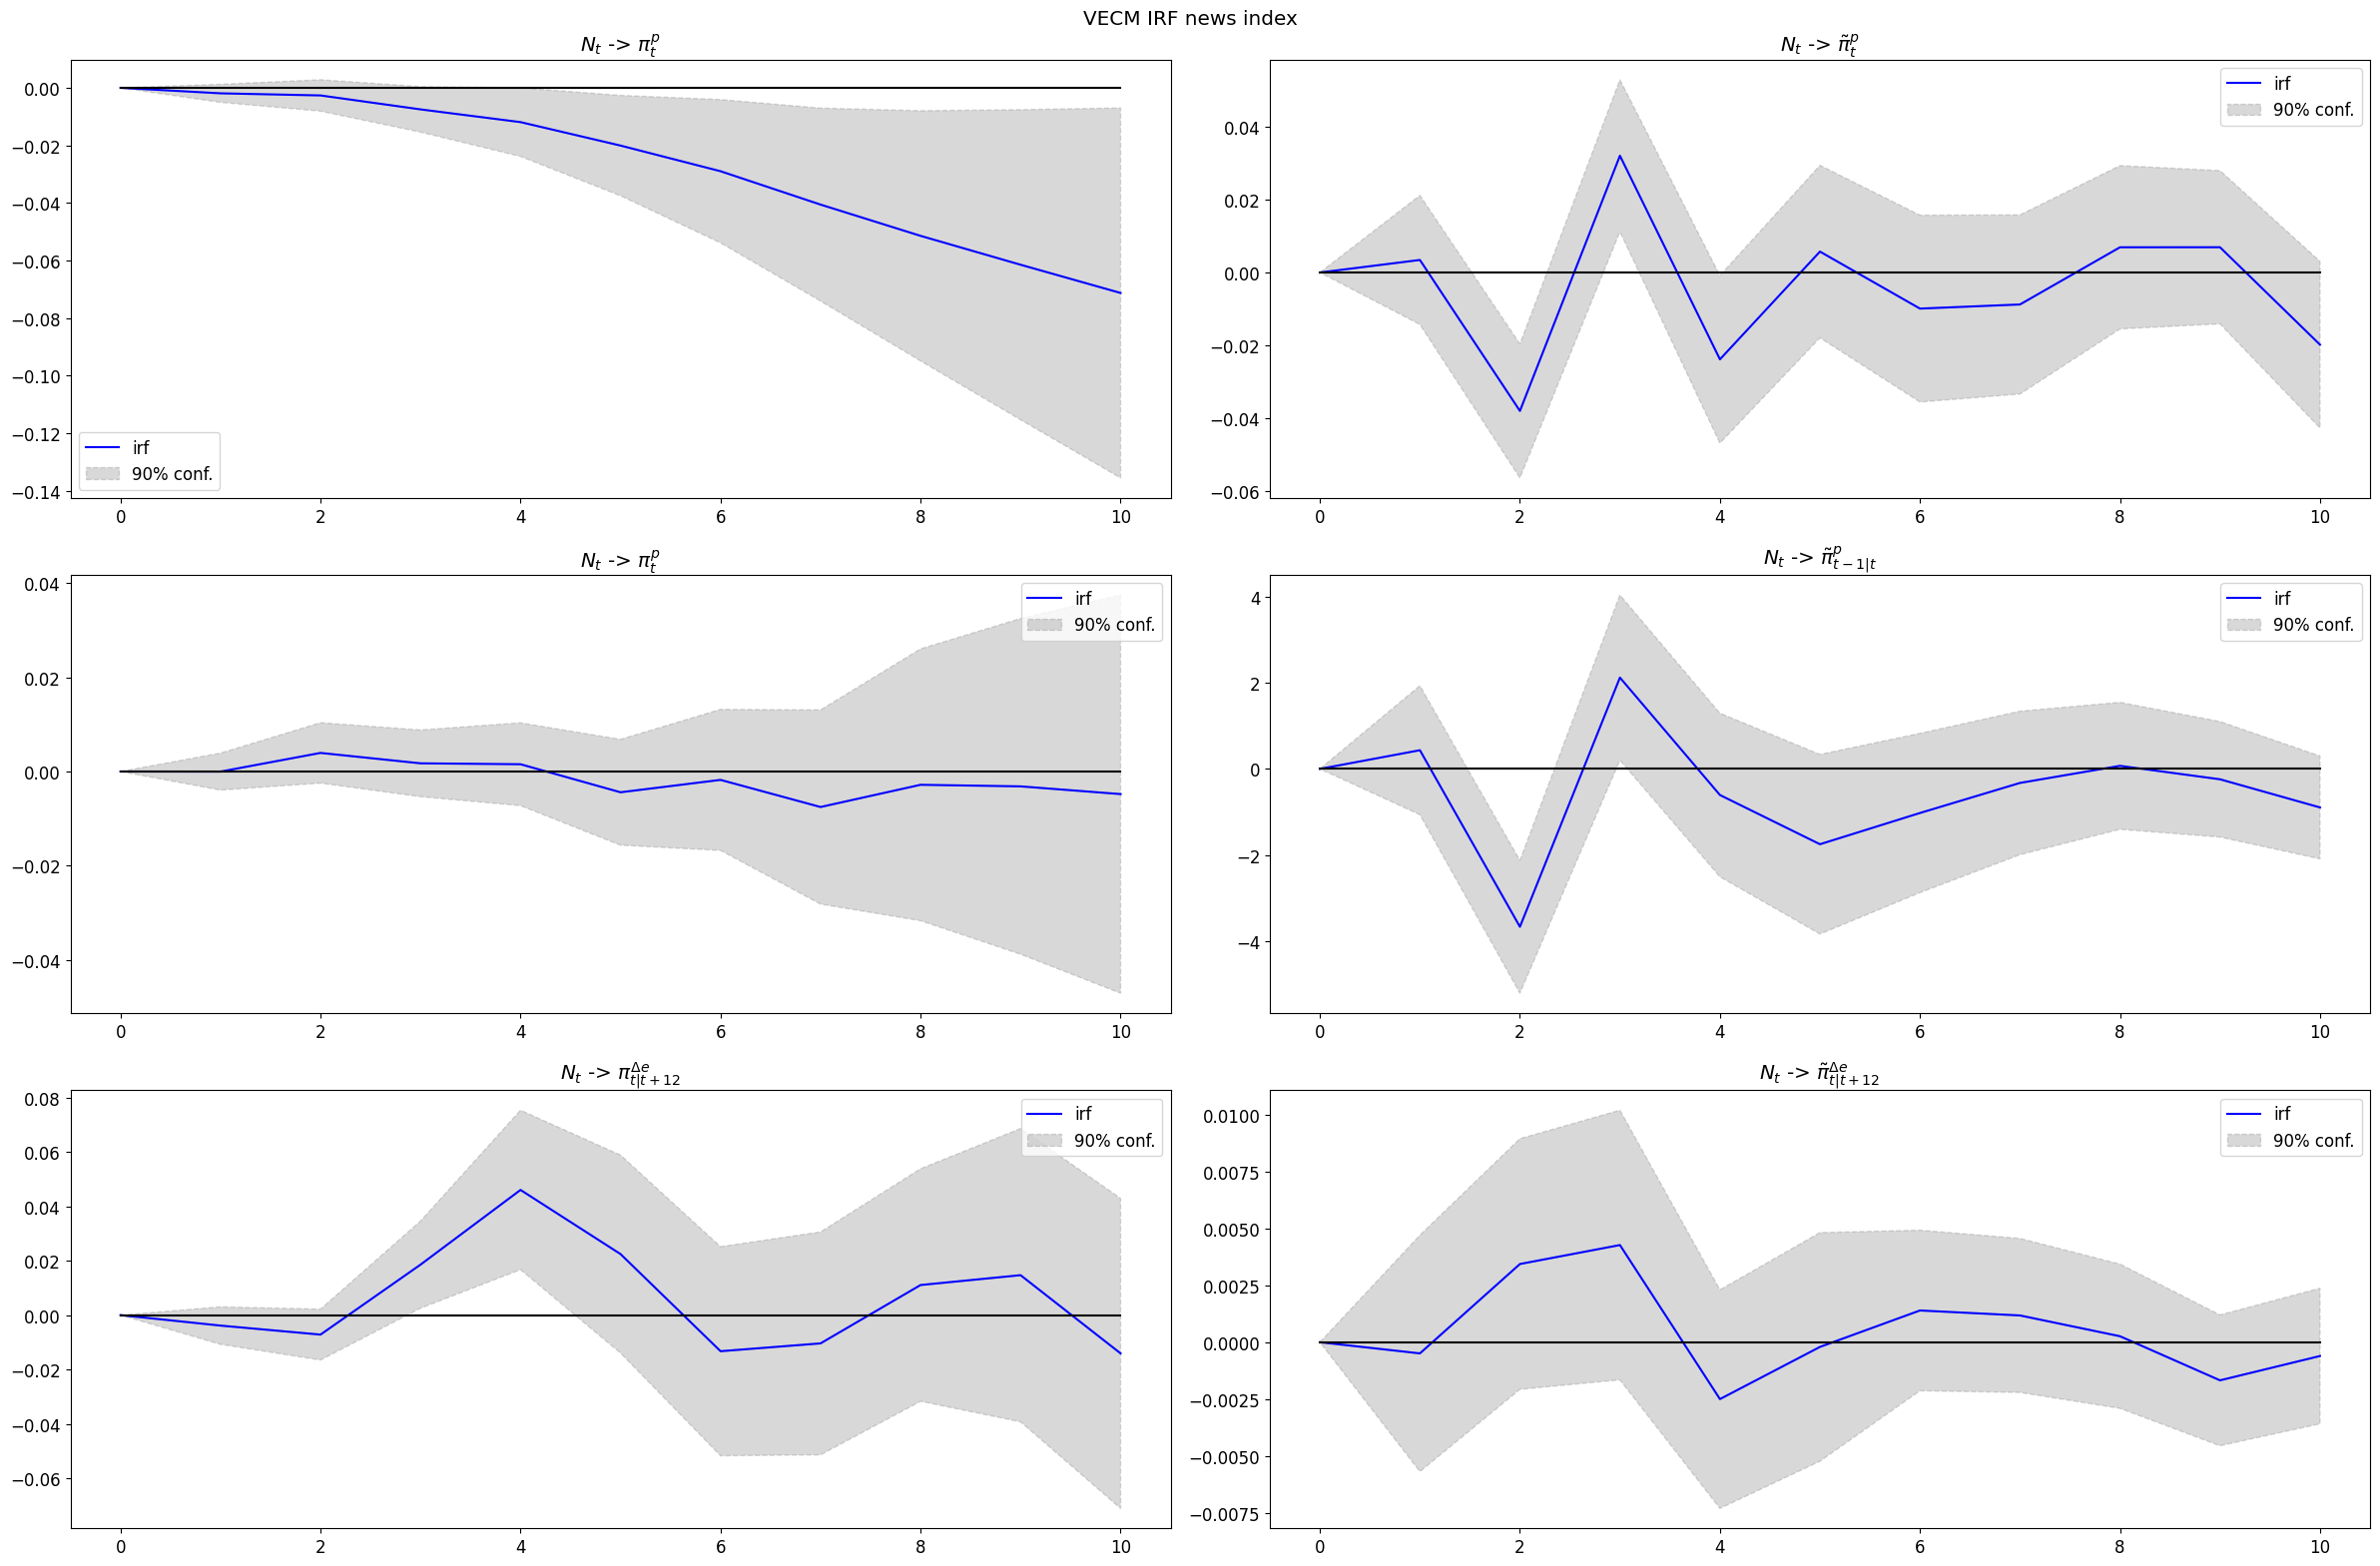

In [80]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum_ind_op": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t-1|t}$",
                                         },
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF news index")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news.png")

## residual normality

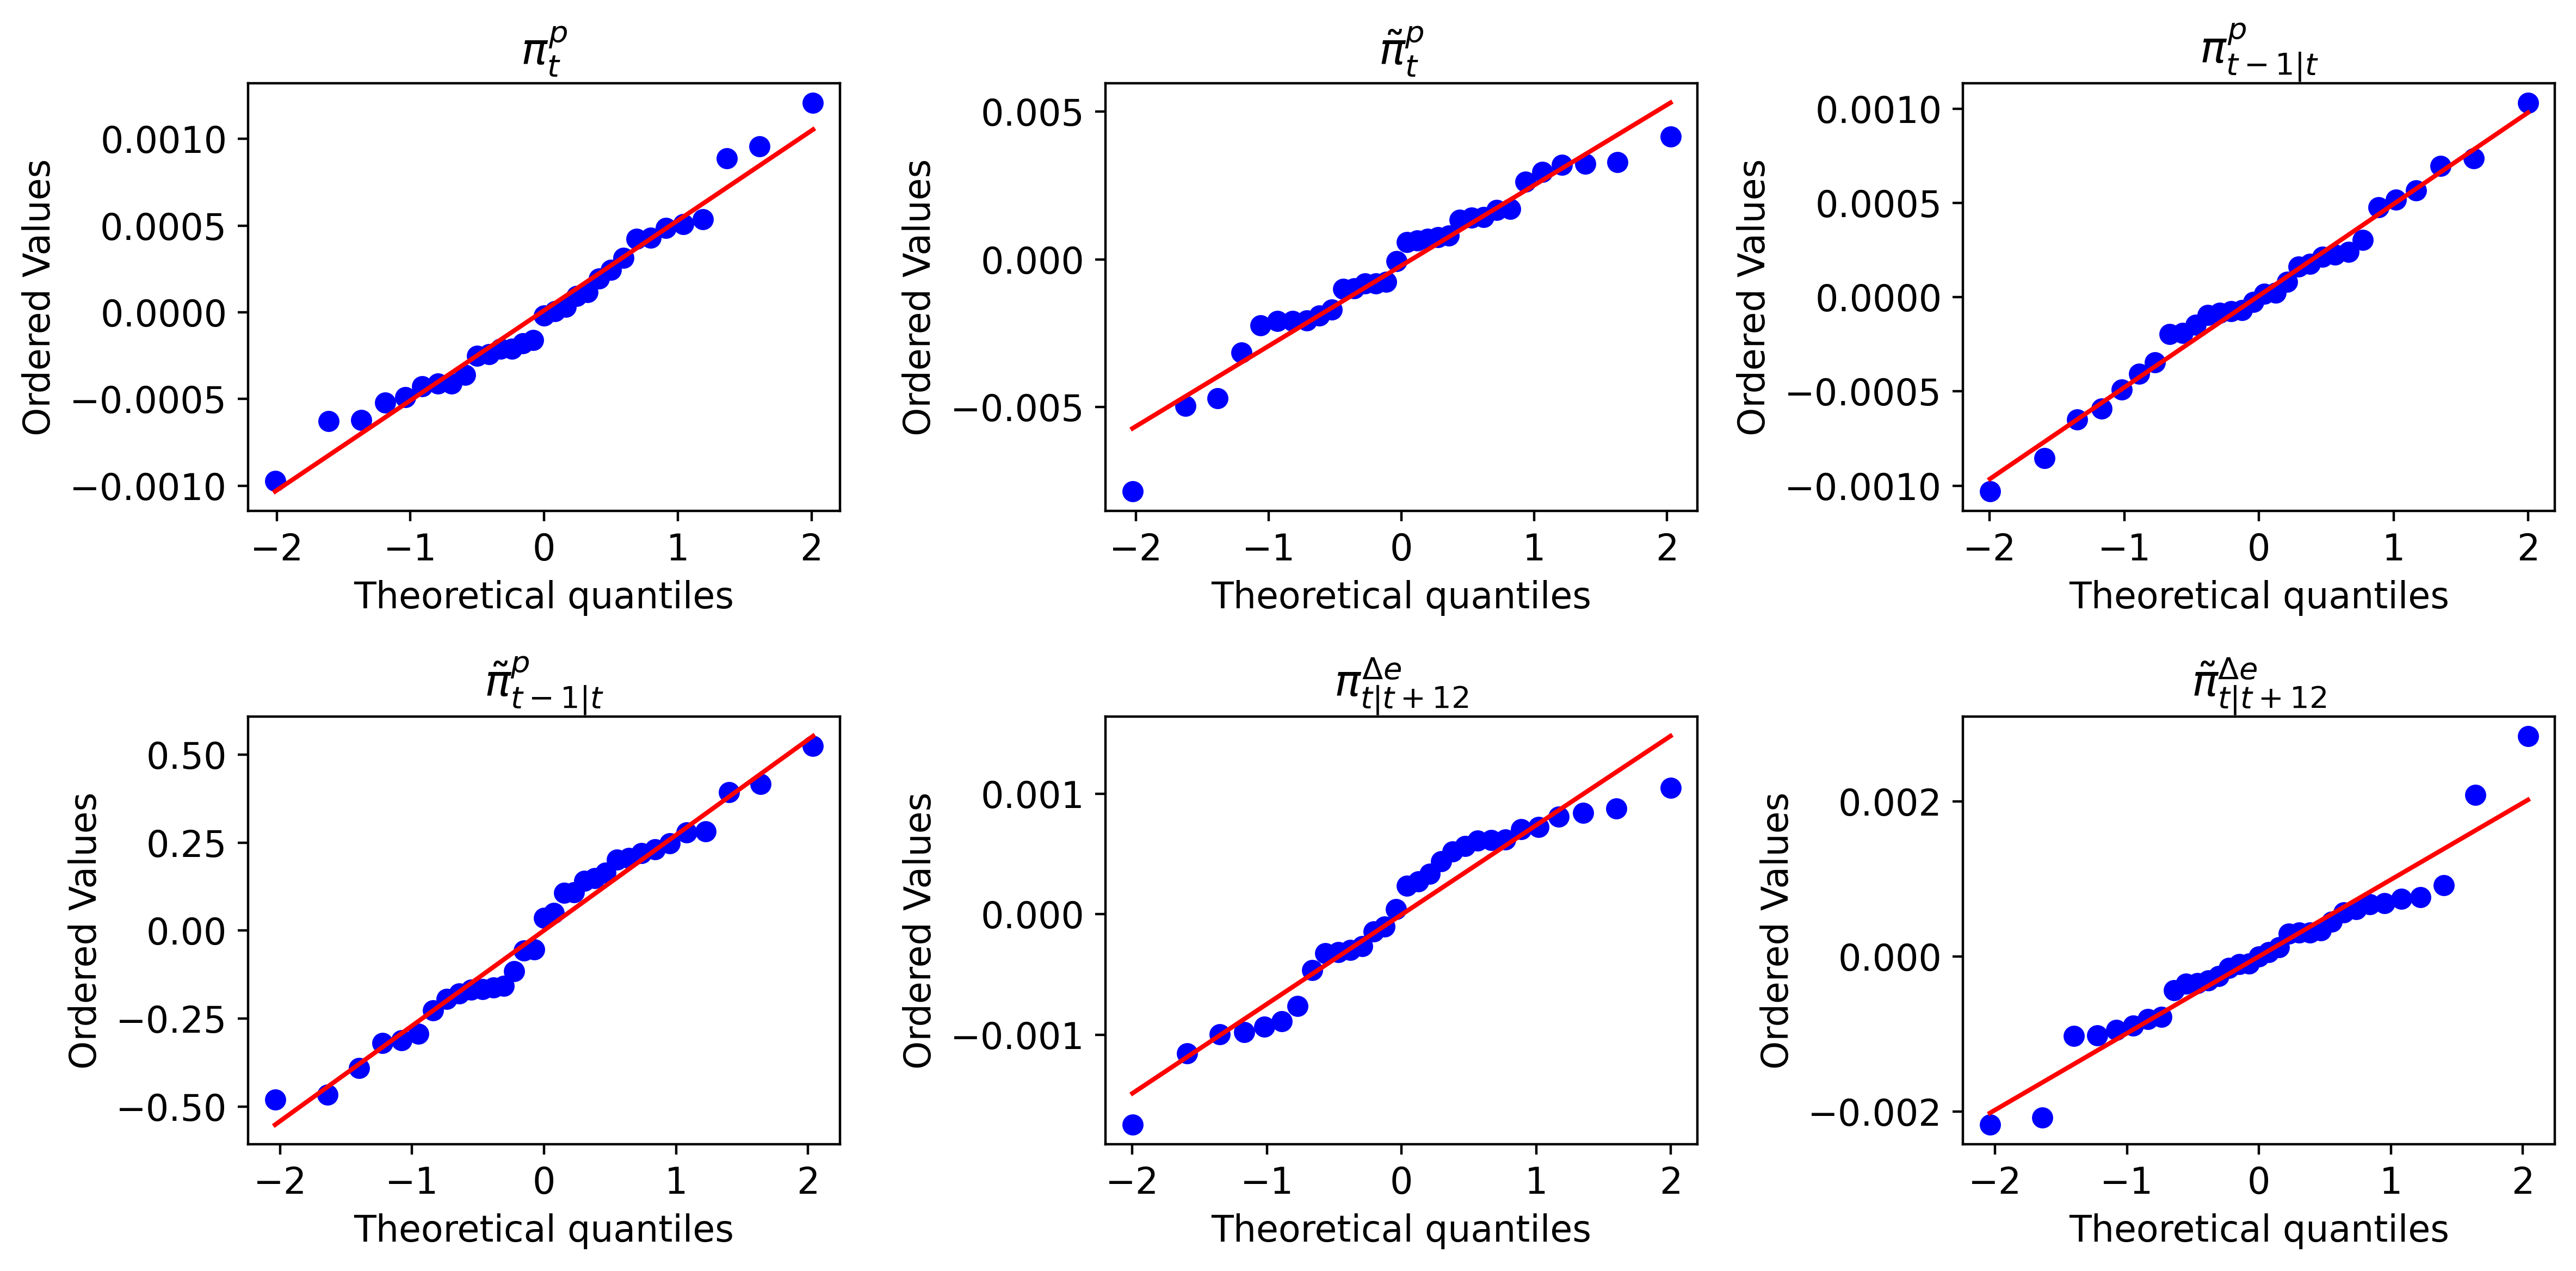

In [84]:
dict_normality = {}
_dict = {'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum_ind_op": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$", "pi_perc_MY_1": "$\pi^p_{t-1|t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t-1|t}$",
                                         }
fig, axes = plt.subplots(2, 3, figsize=(12,6), dpi=400)
for i, mod in enumerate(lst_vecms):
    scipy.stats.probplot(mod.resid[:,0], dist="norm", plot=axes.ravel()[i])
    
    name = mod.model.endog_names[0]
    if name in dict_normality.keys():
        name += "_1"
    
    axes.ravel()[i].set_title(_dict[name]) # + "\n" + f"Het white: homoscedasticity (5% sig) {_}")

    dict_normality[name] = dict(zip(['stat', 'pval',], [mod.test_normality().test_statistic, mod.test_normality().pvalue,]))
    
fig.tight_layout()
save_fig(fig, "fig_vecm_norm.png")

In [86]:
out = pd.DataFrame(dict_normality).T
out['N'] = [len(i.resid) for i in lst_vecms]
out['print'] = out.apply(lambda x: str(~(x['pval']<=.05)) + get_stars(x['pval']) + "\n" + "[" + str(x['stat'].round(3)), axis=1)+"]"

In [88]:
save_pd_df(out[['print', 'N']].T, "tab_normality_vecm.csv")

## investigate seasonality

In [59]:
sub = df.groupby('week_recorded')[['pi_perc_WY', 'pi_exp_WY', 'T_sum_ind_op']].mean().diff()

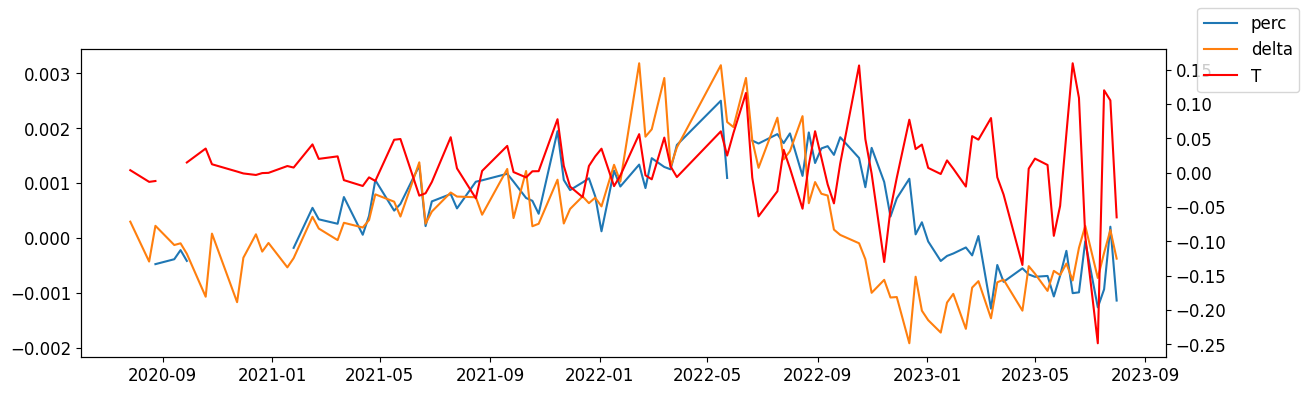

In [60]:
fig, ax = get_fig_subplots()
ax.plot(sub.pi_perc_WY)
ax.plot(sub.pi_exp_WY)
ax.twinx().plot(sub.T_sum_ind_op, color='red')
fig.legend(['perc', 'delta', 'T'])

## output

In [61]:
out = get_statsmodels_summary(lst_vecms, seperator=" ", is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)